#  Rolling Stock Analysis by Alex Dance

In [1]:
print("test")

test


In [2]:
from datetime import timedelta, date,datetime, time 
import pandas as pd
import numpy as np
from scipy import stats, signal
import os
import glob
import gc

In [3]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

In [4]:
# Modelling
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

In [5]:
# Modelling Metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [6]:
from pandas.plotting import scatter_matrix

# Getting Data 

In [7]:
ASX200= pd.read_csv(r'C:/Users/sasha/Alex_Python_Folder/Stock Analysis/General/ASX200shares.csv')

In [8]:
ASX200.head()

,Code,Company
0,A2M,The a2 Milk Company Ltd
1,AAA,Betashares Australian High Interest Cash ETF
2,ABC,Adbri Ltd
3,ABP,Abacus Property Group
4,AFI,Australian Foundation Investment Company Ltd


In [9]:
ASX200 = ASX200.rename(columns={"Code": "share"})

In [10]:
names = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]

In [11]:
day1= pd.read_csv(r'C:/Users/sasha/Alex_Python_Folder/Stock Analysis/StockbyDays/20210719.txt',header=None, names=names)


In [12]:
#print(day1)

In [13]:
day1_WTC =  day1['Close'][(day1.Ticker == "WTC")] 

In [14]:
day1_WTC

2465    30.48
Name: Close, dtype: float64

In [15]:
os.chdir("C:/Users/sasha/Alex_Python_Folder/Stock Analysis/StockbyDays/")

In [16]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [17]:
combined_csv = pd.concat([pd.read_csv(f,header=None, names=names) for f in all_filenames ]) 

In [18]:
#print(all_filenames)

In [19]:
#print(combined_csv)

In [20]:
#export to csv
#combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [21]:
combined_csv.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,14D,20190102,0.31,0.31,0.3,0.3,26036
1,3DP,20190102,0.044,0.045,0.043,0.043,854110
2,3PL,20190102,1.2,1.21,1.195,1.195,101947
3,4CE,20190102,0.015,0.015,0.014,0.014,483448
4,4DS,20190102,0.056,0.059,0.054,0.057,9090917


In [22]:
#combined_csv['Date'].value_counts()

In [23]:
 i = combined_csv[(combined_csv.Ticker == "Code") ].index

In [24]:
combined_csv = combined_csv.drop(i)

In [25]:
Combined = combined_csv.rename(columns={"Ticker": "share"})

In [26]:
Combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2692846 entries, 1 to 2702
Data columns (total 7 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   share   object
 1   Date    object
 2   Open    object
 3   High    object
 4   Low     object
 5   Close   object
 6   Volume  object
dtypes: object(7)
memory usage: 164.4+ MB


In [27]:
Combined.head()

,share,Date,Open,High,Low,Close,Volume
1,3DP,20190102,0.044,0.045,0.043,0.043,854110
2,3PL,20190102,1.2,1.21,1.195,1.195,101947
3,4CE,20190102,0.015,0.015,0.014,0.014,483448
4,4DS,20190102,0.056,0.059,0.054,0.057,9090917
5,5GN,20190102,0.42,0.42,0.42,0.42,3580


In [28]:
Combined.shape

(2692846, 7)

In [29]:
Combined = Combined.rename(columns={"Date": "date"})


In [30]:
#Combined['share'].value_counts() 

In [31]:
Combined['date'] =  pd.to_datetime(Combined['date'] , format='%Y%m%d')

In [32]:
#Combined = Combined [Combined['date'] > '2023-06-01'] ## Key if want more or less data

In [33]:
#Combined['Close'].resample('w').mean().plot()

In [34]:
Combined.shape

(2692846, 7)

In [35]:
Combined[(Combined.share =='OBL')&(Combined.date =='2023-07-17') ]

,share,date,Open,High,Low,Close,Volume
1788,OBL,2023-07-17,2.83,2.86,2.79,2.84,487129


In [36]:
df= Combined.copy() 

In [37]:
df['date_2']=df['date']

In [38]:
#df = df[df.date < '2023-07-01'] # so is and can test vs real results

In [39]:
df = df.set_index('date')

In [40]:
df.head()

,share,Open,High,Low,Close,Volume,date_2
date,,,,,,,
2019-01-02,3DP,0.044,0.045,0.043,0.043,854110,2019-01-02
2019-01-02,3PL,1.2,1.21,1.195,1.195,101947,2019-01-02
2019-01-02,4CE,0.015,0.015,0.014,0.014,483448,2019-01-02
2019-01-02,4DS,0.056,0.059,0.054,0.057,9090917,2019-01-02
2019-01-02,5GN,0.42,0.42,0.42,0.42,3580,2019-01-02


# Delete Combined

In [41]:
del [[Combined]]
gc.collect()
Combined=pd.DataFrame()
Combined.shape

(0, 0)

# Share numbers

In [42]:
df_sharematch =df['share'].value_counts()  

In [43]:
df_sharematch= df_sharematch.reset_index() 
df_sharematch = df_sharematch.rename({'index' : 'share', 'share' : 'history'}, axis=1)

In [44]:
counter = 10000

In [45]:
len(df_sharematch)

4160

In [46]:
for i in range (len(df_sharematch)):
    counter+=1                                                                  
    df_sharematch.loc[i, "ShareNumber"] = counter

In [47]:
df_sharematch.shape

(4160, 3)

In [48]:
df_sharematch.head()

,share,history,ShareNumber
0,SFR,1187,10001.0
1,MND,1187,10002.0
2,MVP,1187,10003.0
3,IEM,1187,10004.0
4,MVA,1187,10005.0


In [49]:
df_sharematch['Code_Length'] = df_sharematch['share'].str.len()

In [50]:
df_sharematch['Code_Length'].value_counts()

3    2862
5     643
4     628
6      27
Name: Code_Length, dtype: int64

In [51]:
df_sharematch = df_sharematch.merge(ASX200, on = ['share'], how="left")

In [52]:
df_sharematch.shape

(4160, 5)

In [53]:
df_sharematch["Name_Length"]= df_sharematch["Company"].str.len()

In [54]:
for i in range (0,len(df_sharematch)) : 
    if df_sharematch.loc[i, 'Name_Length']> 1: 
        df_sharematch.loc[i, 'ASX200'] = 1
    else:
        df_sharematch.loc[i, 'ASX200'] =0

In [55]:
df_sharematch.head()

,share,history,ShareNumber,Code_Length,Company,Name_Length,ASX200
0,SFR,1187,10001.0,3,NaN,NaN,0.0
1,MND,1187,10002.0,3,NaN,NaN,0.0
2,MVP,1187,10003.0,3,NaN,NaN,0.0
3,IEM,1187,10004.0,3,NaN,NaN,0.0
4,MVA,1187,10005.0,3,NaN,NaN,0.0


In [56]:
df_sharematch.shape

(4160, 7)

In [57]:
max_number_days_in_data = df_sharematch['history'].max()

In [58]:
print(max_number_days_in_data)

1187


In [59]:
#df_sharematch['history'].value_counts()

In [60]:
df_sharematch = df_sharematch[df_sharematch.history > (max_number_days_in_data/2)]

In [61]:
df_sharematch.shape

(2229, 7)

In [62]:
df_sharematch_ASX200 = df_sharematch[['share','ASX200']]
df_sharematch_Limited=  df_sharematch[['share','ASX200', 'ShareNumber','Code_Length']]

In [63]:
df = df.reset_index()

In [64]:
df = df.merge(df_sharematch_Limited, on = ['share'])

In [65]:
df = df[df.Code_Length ==3] # as a lot > 3 are variations don't want to look at

In [66]:
#df_sharematch['history'].value_counts()

In [67]:
df_sharematch['history'].max()

1187

In [68]:
del [[df_sharematch_Limited]]
gc.collect()
df_sharematch_Limited=pd.DataFrame()
df_sharematch_Limited.shape

(0, 0)

In [69]:
df[ (df.share == "ODA") &(df.date == '2023-07-19')]

,date,share,Open,High,Low,Close,Volume,date_2,ASX200,ShareNumber,Code_Length
1364013,2023-07-19,ODA,0.265,0.295,0.265,0.295,366691,2023-07-19,0.0,11002.0,3


# Get looking all good 

In [70]:
df['Volume'] = df['Volume'].astype(int)
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

In [71]:
df.head()

,date,share,Open,High,Low,Close,Volume,date_2,ASX200,ShareNumber,Code_Length
0,2019-01-02,3DP,0.044,0.045,0.043,0.043,854110,2019-01-02,0.0,10483.0,3
1,2019-01-03,3DP,0.042,0.043,0.042,0.043,550000,2019-01-03,0.0,10483.0,3
2,2019-01-07,3DP,0.043,0.045,0.042,0.042,1021235,2019-01-07,0.0,10483.0,3
3,2019-01-08,3DP,0.043,0.043,0.042,0.042,259262,2019-01-08,0.0,10483.0,3
4,2019-01-09,3DP,0.043,0.048,0.042,0.046,3339082,2019-01-09,0.0,10483.0,3


In [72]:
#df.sort_values(by=['Close'],  ascending=False)

# Close Extremes Removed

In [73]:
AvgClose = (df.groupby('share')['Close'].mean()).reset_index()

In [74]:
AvgClose.head()

,share,Close
0,14D,0.127250
1,1AD,0.092874
2,1AG,0.029253
3,1ST,0.027422
4,2BE,0.087885


In [75]:
AvgClose = AvgClose.rename(columns={"Close": "Avg_Close_Over_Period"})

In [76]:
AvgClose = AvgClose[AvgClose.Avg_Close_Over_Period < 300]

In [77]:
AvgClose = AvgClose[AvgClose.Avg_Close_Over_Period > 0.05]

In [78]:
AvgClose = AvgClose.reset_index()

In [79]:
df = df.merge(AvgClose, on = ['share'])

In [80]:
df = df.drop(['Avg_Close_Over_Period'],axis = 1) # as it bleeds data

In [81]:
#df.sort_values(by=['Close'])

In [82]:
# Open Close Etc Ratios

In [83]:
df.head()

,date,share,Open,High,Low,Close,Volume,date_2,ASX200,ShareNumber,Code_Length,index
0,2019-01-02,3DP,0.044,0.045,0.043,0.043,854110,2019-01-02,0.0,10483.0,3,6
1,2019-01-03,3DP,0.042,0.043,0.042,0.043,550000,2019-01-03,0.0,10483.0,3,6
2,2019-01-07,3DP,0.043,0.045,0.042,0.042,1021235,2019-01-07,0.0,10483.0,3,6
3,2019-01-08,3DP,0.043,0.043,0.042,0.042,259262,2019-01-08,0.0,10483.0,3,6
4,2019-01-09,3DP,0.043,0.048,0.042,0.046,3339082,2019-01-09,0.0,10483.0,3,6


In [84]:
df[(df.share =='OBL')&(df.date =='2023-07-17') ]

,date,share,Open,High,Low,Close,Volume,date_2,ASX200,ShareNumber,Code_Length,index
1470742,2023-07-17,OBL,2.83,2.86,2.79,2.84,487129,2023-07-17,0.0,11556.0,3,1292


In [85]:
Max_df_date = df['date'].max()

In [86]:
print(Max_df_date)

2023-10-20 00:00:00


In [87]:
#_= dummy2[['VolumeCompare', 'Close']].plot(figsize=(15, 5))

# Add Features

In [88]:
df = df.reset_index()

In [89]:
df = df.sort_values(by=['share','date'])

In [90]:
df['Rolling-10'] = df.groupby('share')['Close'].rolling(10).mean().reset_index(0,drop=True)
df['Rolling-30'] = df.groupby('share')['Close'].rolling(30).mean().reset_index(0,drop=True)

In [91]:
df['Future-1'] = df.groupby('share')['Close'].shift(-1)
df['Future-2'] = df.groupby('share')['Close'].shift(-2)
df['Future-3'] = df.groupby('share')['Close'].shift(-3)
df['Future-7'] = df.groupby('share')['Close'].shift(-7)
df['Future-14'] = df.groupby('share')['Close'].shift(-14)
df['Future-21'] = df.groupby('share')['Close'].shift(-21)
df['Future-28'] = df.groupby('share')['Close'].shift(-28)
df['Future-60'] = df.groupby('share')['Close'].shift(-60)
df['Future-160'] = df.groupby('share')['Close'].shift(-160)
df['Future-320'] = df.groupby('share')['Close'].shift(-320)

In [92]:
#df['Future-1'].info # = df['Future-1'].astype(int)

In [93]:
df['Compare_F1'] = df['Future-1'] - df['Close'] 
df['Compare_F2'] = df['Future-2'] - df['Close']  
df['Compare_F3'] = df['Future-3'] - df['Close']  
df['Compare_F7'] = df['Future-7'] - df['Close']  
df['Compare_F14'] = df['Future-14'] - df['Close']  
df['Compare_F21'] = df['Future-21'] - df['Close']  
df['Compare_F28'] = df['Future-28'] - df['Close']  
df['Compare_F60'] = df['Future-60'] - df['Close']  

In [94]:
df['Compare_F1_rat'] = df['Future-1'] / df['Close'] 
df['Compare_F2_rat'] = df['Future-2'] / df['Close'] 
df['Compare_F3_rat'] = df['Future-3'] / df['Close'] 
df['Compare_F7_rat'] = df['Future-7'] / df['Close'] 
df['Compare_F14_rat'] = df['Future-14'] / df['Close'] 
df['Compare_F21_rat'] = df['Future-21'] / df['Close'] 
df['Compare_F28_rat'] = df['Future-28'] / df['Close'] 
df['Compare_F60_rat'] = df['Future-60'] / df['Close'] 

In [95]:
df = df.set_index('date')

In [96]:
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek

<Axes: xlabel='date'>

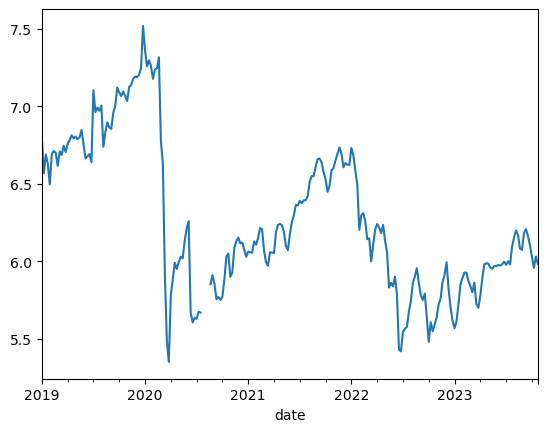

In [97]:
#df = df.set_index('date')
df['Close'].resample('w').mean().plot()

# Preparing File

In [98]:
df = df.reset_index()

In [99]:
df_temp = df.copy()

In [100]:
df.describe()

,level_0,Open,High,Low,Close,Volume,ASX200,ShareNumber,Code_Length,index,...,Compare_F3_rat,Compare_F7_rat,Compare_F14_rat,Compare_F21_rat,Compare_F28_rat,Compare_F60_rat,day,month,year,dayofweek
count,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06,1603164.0,1.603164e+06,...,1.598502e+06,1.592286e+06,1.581408e+06,1.570530e+06,1.559652e+06,1.509924e+06,1.603164e+06,1.603164e+06,1.603164e+06,1.603164e+06
mean,8.015815e+05,6.239959e+00,6.294316e+00,6.179971e+00,6.235839e+00,1.212451e+06,1.371575e-01,1.086631e+04,3.0,9.876846e+02,...,1.009549e+00,1.022114e+00,1.043626e+00,1.064705e+00,1.085730e+00,1.179937e+00,1.568524e+01,6.417238e+00,2.021042e+03,2.022116e+00
std,4.627937e+05,2.126325e+01,2.139672e+01,2.111260e+01,2.125121e+01,4.568524e+06,3.440137e-01,6.028336e+02,0.0,5.655414e+02,...,9.454584e-01,1.513366e+00,2.145376e+00,2.611143e+00,2.998631e+00,4.268135e+00,8.720709e+00,3.376726e+00,1.338847e+00,1.403721e+00
min,0.000000e+00,1.000000e-03,1.000000e-03,1.000000e-03,1.000000e-03,0.000000e+00,0.000000e+00,1.000100e+04,3.0,0.000000e+00,...,2.739726e-03,2.739726e-03,2.465753e-03,2.459016e-03,2.191781e-03,1.643836e-03,1.000000e+00,1.000000e+00,2.019000e+03,0.000000e+00
25%,4.007908e+05,1.450000e-01,1.500000e-01,1.400000e-01,1.450000e-01,2.491800e+04,0.000000e+00,1.036500e+04,3.0,4.960000e+02,...,9.715302e-01,9.562500e-01,9.354839e-01,9.189189e-01,9.047619e-01,8.536585e-01,8.000000e+00,3.000000e+00,2.020000e+03,1.000000e+00
50%,8.015815e+05,6.100000e-01,6.200000e-01,6.000000e-01,6.050000e-01,1.754140e+05,0.000000e+00,1.075300e+04,3.0,9.890000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.915254e-01,1.600000e+01,6.000000e+00,2.021000e+03,2.000000e+00
75%,1.202372e+06,2.780000e+00,2.820000e+00,2.730000e+00,2.770000e+00,8.156740e+05,0.000000e+00,1.130600e+04,3.0,1.471000e+03,...,1.023478e+00,1.035975e+00,1.052565e+00,1.065961e+00,1.077261e+00,1.116279e+00,2.300000e+01,9.000000e+00,2.022000e+03,3.000000e+00
max,1.603163e+06,3.999700e+02,3.999700e+02,3.984700e+02,3.999500e+02,7.182258e+08,1.000000e+00,1.222900e+04,3.0,1.989000e+03,...,3.800000e+02,4.462500e+02,4.587500e+02,4.687500e+02,4.687500e+02,4.925000e+02,3.100000e+01,1.200000e+01,2.023000e+03,4.000000e+00


In [101]:
df['date-2'] = df['date']

In [102]:
df['date-3'] = df['date']

In [103]:
df_date_index = df.copy() 

In [104]:
df_date_index = df_date_index.set_index('date')

In [105]:
df_std_index = df.copy() 

In [106]:
df_date_index.head()

,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,ShareNumber,...,Compare_F14_rat,Compare_F21_rat,Compare_F28_rat,Compare_F60_rat,day,month,year,dayofweek,date-2,date-3
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,1410602,14D,0.280,0.280,0.275,0.275,43731,2019-07-10,0.0,11134.0,...,1.018182,0.981818,0.927273,0.709091,10,7,2019,2,2019-07-10,2019-07-10
2019-07-11,1410603,14D,0.280,0.295,0.280,0.285,329202,2019-07-11,0.0,11134.0,...,0.947368,0.947368,0.912281,0.701754,11,7,2019,3,2019-07-11,2019-07-11
2019-07-12,1410604,14D,0.290,0.290,0.280,0.285,173125,2019-07-12,0.0,11134.0,...,0.982456,0.929825,0.894737,0.666667,12,7,2019,4,2019-07-12,2019-07-12
2019-07-15,1410605,14D,0.290,0.290,0.285,0.285,36296,2019-07-15,0.0,11134.0,...,0.947368,0.929825,0.824561,0.666667,15,7,2019,0,2019-07-15,2019-07-15
2019-07-16,1410606,14D,0.285,0.285,0.285,0.285,5600,2019-07-16,0.0,11134.0,...,0.929825,0.929825,0.859649,0.614035,16,7,2019,1,2019-07-16,2019-07-16


In [107]:
df_std_index.head()

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,Compare_F14_rat,Compare_F21_rat,Compare_F28_rat,Compare_F60_rat,day,month,year,dayofweek,date-2,date-3
0,2019-07-10,1410602,14D,0.280,0.280,0.275,0.275,43731,2019-07-10,0.0,...,1.018182,0.981818,0.927273,0.709091,10,7,2019,2,2019-07-10,2019-07-10
1,2019-07-11,1410603,14D,0.280,0.295,0.280,0.285,329202,2019-07-11,0.0,...,0.947368,0.947368,0.912281,0.701754,11,7,2019,3,2019-07-11,2019-07-11
2,2019-07-12,1410604,14D,0.290,0.290,0.280,0.285,173125,2019-07-12,0.0,...,0.982456,0.929825,0.894737,0.666667,12,7,2019,4,2019-07-12,2019-07-12
3,2019-07-15,1410605,14D,0.290,0.290,0.285,0.285,36296,2019-07-15,0.0,...,0.947368,0.929825,0.824561,0.666667,15,7,2019,0,2019-07-15,2019-07-15
4,2019-07-16,1410606,14D,0.285,0.285,0.285,0.285,5600,2019-07-16,0.0,...,0.929825,0.929825,0.859649,0.614035,16,7,2019,1,2019-07-16,2019-07-16


In [108]:
len(df_sharematch)

2229

In [109]:
df_date_index['Previous-1'] = df.groupby('share')['Close'].shift(1)

In [110]:
#df_date_index.info()

In [111]:
import warnings
warnings.simplefilter('always')

In [112]:
pd.set_option('mode.chained_assignment', None)
pd.reset_option("mode.chained_assignment")
pd.set_option('mode.chained_assignment', None)

In [113]:
def BuyCrossingCalculate (rolling_lower,rolling_higher,sharecoming):
    datafile = df_date_index[df_date_index.share == sharecoming]
    previous_low = datafile[rolling_lower].shift(1)
    previous_high = datafile[rolling_higher].shift(1)
    buy_crossing = ((datafile[rolling_lower]  > datafile[rolling_higher]) & (previous_low < previous_high))  
    datafile ['Buy-Rolling-10-30-Cross'] = buy_crossing
    return (datafile)

In [114]:
def SellCrossingCalculate (rolling_lower,rolling_higher,sharecoming):
    datafile = df_date_index[df_date_index.share == sharecoming]
    previous_low = datafile[rolling_lower].shift(1)
    previous_high = datafile[rolling_higher].shift(1)
    sell_crossing = ((datafile[rolling_lower] < datafile[rolling_higher]) & (previous_low > previous_high))
    datafile ['Sell-Rolling-10-30-Cross'] = sell_crossing   
    #print(datafile)
    return (datafile)

In [115]:

num_shares_checking = len(df_sharematch ) #1000

for i in range (1,  num_shares_checking): #num_shares_checking):  # i is share number
    share = df_sharematch.loc[i, "share"]
    #print( share + " - " + str( i) )

    if (i % 100 == 0): 
        print( share + " - " + str( i) +  " - " + str("{:.0%}".format(i/num_shares_checking))) 
    
    LowCrossingNumber = 10
    HighCrossingNumber = 30

    sharepass = share
    Rolling_Low = 'Rolling-'+ str(LowCrossingNumber)
    Rolling_High = 'Rolling-'+ str(HighCrossingNumber)
  
    cross_buy_get  = BuyCrossingCalculate (Rolling_Low,Rolling_High,sharepass)
    cross_sell_get  = SellCrossingCalculate (Rolling_Low,Rolling_High,sharepass)
   
    cross_buy_get_want = cross_buy_get [['Buy-Rolling-10-30-Cross','share']]
    cross_sell_get_want = cross_sell_get [['Sell-Rolling-10-30-Cross','share']]#,'date-2']]
    
    #df_temp_combo_buy = df_std_index.merge(cross_buy_get_want, on = ['date','share'], how = 'left') 
    #df_temp_combo = df_temp_combo_buy.merge(cross_sell_get_want, on = ['date','share'], how = 'left') 
    
    df_temp_combo_buy = df_std_index.merge(cross_buy_get_want, on = ['date','share'], how = 'inner') 
    df_temp_combo = df_temp_combo_buy.merge(cross_sell_get_want, on = ['date','share'], how = 'inner') 
    
    if i== 1:
        new_df = df_temp_combo
    else:
        new_df= pd.concat([new_df,df_temp_combo])
   

    #print(i)
    #print(cross_buy_get_want.groupby(['share']).count())
    #print(new_df[(new_df.share =='OBL')&(new_df.date =='2023-07-17') ])
 

WGB - 100 - 4%
FMG - 200 - 9%
NCM - 300 - 13%
VHT - 400 - 18%
AXE - 500 - 22%
PRT - 600 - 27%
CHK - 700 - 31%
BOL - 800 - 36%
8CO - 900 - 40%
ADR - 1000 - 45%
TDO - 1100 - 49%
BLZ - 1200 - 54%
HMC - 1300 - 58%
MME - 1400 - 63%
ACU - 1500 - 67%
ACS - 1600 - 72%
IEQ - 1700 - 76%
PYG - 1800 - 81%
VETH - 1900 - 85%
SOV - 2000 - 90%
PNL - 2100 - 94%
GTI - 2200 - 99%


In [116]:
#df_temp_combo_buy.head()

In [117]:
#df_std_index.head()

In [118]:
#df_temp_combo.head()

In [119]:
#cross_sell_get.head()

In [120]:
#cross_buy_get.head()

In [121]:
#new_df.info()

In [122]:
new_df['Buy-Rolling-10-30-Cross'].value_counts()

False    1572972
True       29005
Name: Buy-Rolling-10-30-Cross, dtype: int64

In [123]:
#df_temp_combo.sample (5)

In [124]:
df_temp_combo['Buy-Rolling-10-30-Cross'].value_counts()

False    581
True      13
Name: Buy-Rolling-10-30-Cross, dtype: int64

In [125]:
new_df['Buy-Rolling-10-30-Cross'].value_counts()

False    1572972
True       29005
Name: Buy-Rolling-10-30-Cross, dtype: int64

In [126]:
#df_temp_combo.head()

del [[df_temp_combo]]
gc.collect()
df_temp_combo=pd.DataFrame()
df_temp_combo.shape

del [[df_date_index]]
gc.collect()
df_date_index=pd.DataFrame()
df_date_index.shape

del [[df_std_index]]
gc.collect()
df_std_index=pd.DataFrame()
df_std_index.shape

# Preparation of File and clean up

In [127]:
df = new_df.copy()

In [128]:
del [[new_df]]
gc.collect()
new_df=pd.DataFrame()
new_df.shape

(0, 0)

In [129]:
del [[cross_buy_get_want]]
gc.collect()
cross_buy_get_want=pd.DataFrame()
cross_buy_get_want.shape

(0, 0)

In [130]:
del [[cross_sell_get_want]]
gc.collect()
cross_sell_get_want=pd.DataFrame()
cross_sell_get_want.shape

(0, 0)

In [131]:
del [[df_temp_combo_buy]]
gc.collect()
df_temp_combo_buy=pd.DataFrame()
df_temp_combo_buy.shape

(0, 0)

# Print 

In [390]:
#df = df.set_index('date')
dummyprinta = df[(df.share == "WBC")&(df.date_2 > '2021-03-01')] #WBC
#_= dummyprint['Close'].plot(figsize=(15, 5))
dummyprinta = dummyprinta.set_index('date')
_= dummyprinta[['Close','Rolling-10',  'Rolling-30']].plot(figsize=(15, 10))

KeyError: "None of ['date'] are in the columns"

# Get angles when cross to see if make a difference

In [133]:
df['Rolling-10-Previous-1'] = df.groupby('share')['Rolling-10'].shift(1)

In [134]:
df['Rolling10Previous1Ratio'] = df['Rolling-10'] / df['Rolling-10-Previous-1']

In [135]:
df.shape

(1601977, 51)

In [136]:
df['Rolling-30-Previous-1'] = df.groupby('share')['Rolling-30'].shift(1)

In [137]:
df['Rolling30Previous1Ratio'] = df['Rolling-30'] / df['Rolling-30-Previous-1'] 

In [138]:
df.sample(5)

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,year,dayofweek,date-2,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio
1114,2023-09-25,1023920,WLD,0.039,0.039,0.039,0.039,0,2023-09-25,0.0,...,2023,0,2023-09-25,2023-09-25,False,False,0.0410,0.987805,0.044167,0.993208
360,2020-10-13,106811,ASG,1.380,1.400,1.380,1.400,11390,2020-10-13,0.0,...,2020,1,2020-10-13,2020-10-13,False,False,1.3215,1.006432,1.331500,1.003254
382,2020-11-26,1121151,PDI,0.057,0.060,0.057,0.058,3809784,2020-11-26,0.0,...,2020,3,2020-11-26,2020-11-26,False,False,0.0650,0.986154,0.062733,0.997875
38,2019-05-01,1273591,NC6,0.061,0.061,0.061,0.061,15573,2019-05-01,0.0,...,2019,2,2019-05-01,2019-05-01,False,False,0.0621,0.993559,0.077367,0.974580
1123,2023-08-08,1179289,EVS,0.096,0.096,0.093,0.093,479702,2023-08-08,0.0,...,2023,1,2023-08-08,2023-08-08,False,False,0.0938,1.004264,0.091767,1.004359


In [139]:
#df.info()

# Good Comparison

In [140]:
df.groupby(['Buy-Rolling-10-30-Cross'])['Compare_F7_rat'].mean()

Buy-Rolling-10-30-Cross
False    1.022085
True     1.024501
Name: Compare_F7_rat, dtype: float64

In [141]:
df.groupby(['Buy-Rolling-10-30-Cross'])['Rolling10Previous1Ratio'].mean()

Buy-Rolling-10-30-Cross
False    0.999815
True     1.017703
Name: Rolling10Previous1Ratio, dtype: float64

In [142]:
df['Rolling10Previous1Ratio'].sample(10)

585     0.983707
1139    0.998536
404     1.036730
463     0.990521
421     1.000000
692     1.000000
564     0.977064
1050    1.001778
113     1.002824
993     1.025000
Name: Rolling10Previous1Ratio, dtype: float64

In [143]:
bins_Ratio = np.array([0,0.9,0.95,0.97,0.98, 0.99,0.995, 1,1.05,1.1,2])
df["Rolling10Previous1Ratio_Bucket"] = pd.cut(df.Rolling10Previous1Ratio, bins_Ratio)

In [144]:
df.groupby(['Rolling10Previous1Ratio_Bucket'])['Compare_F7_rat'].mean()

Rolling10Previous1Ratio_Bucket
(0.0, 0.9]       1.232455
(0.9, 0.95]      1.321767
(0.95, 0.97]     1.064776
(0.97, 0.98]     1.023118
(0.98, 0.99]     1.038186
(0.99, 0.995]    1.009779
(0.995, 1.0]     1.022062
(1.0, 1.05]      1.017478
(1.05, 1.1]      1.045982
(1.1, 2.0]       1.012534
Name: Compare_F7_rat, dtype: float64

In [145]:
df.groupby(['Rolling10Previous1Ratio_Bucket'])['Compare_F7_rat'].count()

Rolling10Previous1Ratio_Bucket
(0.0, 0.9]          564
(0.9, 0.95]        5180
(0.95, 0.97]      19762
(0.97, 0.98]      44149
(0.98, 0.99]     155274
(0.99, 0.995]    193095
(0.995, 1.0]     456867
(1.0, 1.05]      690480
(1.05, 1.1]        8037
(1.1, 2.0]         2100
Name: Compare_F7_rat, dtype: int64

In [146]:
df.groupby(['Buy-Rolling-10-30-Cross','Rolling10Previous1Ratio_Bucket'])['Compare_F7_rat'].mean()

Buy-Rolling-10-30-Cross  Rolling10Previous1Ratio_Bucket
False                    (0.0, 0.9]                        1.232455
                         (0.9, 0.95]                       1.321767
                         (0.95, 0.97]                      1.064776
                         (0.97, 0.98]                      1.023114
                         (0.98, 0.99]                      1.038173
                         (0.99, 0.995]                     1.009567
                         (0.995, 1.0]                      1.022087
                         (1.0, 1.05]                       1.017208
                         (1.05, 1.1]                       1.049181
                         (1.1, 2.0]                        1.013025
True                     (0.0, 0.9]                             NaN
                         (0.9, 0.95]                            NaN
                         (0.95, 0.97]                           NaN
                         (0.97, 0.98]                      1

# Possibilities to Buy

In [147]:
possible1 = df[df['Buy-Rolling-10-30-Cross']==True]

In [148]:
possible1.shape

(29005, 54)

In [149]:
possible2 = possible1[possible1['date'] ==possible1['date'].max()]

In [150]:
possible2.shape

(40, 54)

In [151]:
possible3 = possible2[possible2['Rolling30Previous1Ratio'] > 1]

In [152]:
possible3.shape

(17, 54)

In [153]:
possible3.head()

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,dayofweek,date-2,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket
1186,2023-10-20,778573,QAU,16.70,16.760,16.670,16.74,81816,2023-10-20,0.0,...,4,2023-10-20,2023-10-20,True,False,15.9820,1.007884,16.085000,1.000767,"(1.0, 1.05]"
1186,2023-10-20,343083,EVN,3.62,3.720,3.575,3.68,11093053,2023-10-20,1.0,...,4,2023-10-20,2023-10-20,True,False,3.5030,1.011990,3.518667,1.001326,"(1.0, 1.05]"
1186,2023-10-20,10106,AAA,50.18,50.190,50.180,50.19,266083,2023-10-20,1.0,...,4,2023-10-20,2023-10-20,True,False,50.1495,1.000160,50.153500,1.000060,"(1.0, 1.05]"
1186,2023-10-20,906193,STO,7.95,8.055,7.900,8.00,14125493,2023-10-20,1.0,...,4,2023-10-20,2023-10-20,True,False,7.6860,1.007546,7.730000,1.000302,"(1.0, 1.05]"
1186,2023-10-20,743681,PMC,1.31,1.315,1.300,1.31,152522,2023-10-20,0.0,...,4,2023-10-20,2023-10-20,True,False,1.2855,1.003112,1.286500,1.000000,"(1.0, 1.05]"


In [154]:
possible3[['date', 'share', 'Close','Buy-Rolling-10-30-Cross','Sell-Rolling-10-30-Cross','Rolling10Previous1Ratio','Rolling30Previous1Ratio']].head(5)

,date,share,Close,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling10Previous1Ratio,Rolling30Previous1Ratio
1186,2023-10-20,QAU,16.74,True,False,1.007884,1.000767
1186,2023-10-20,EVN,3.68,True,False,1.011990,1.001326
1186,2023-10-20,AAA,50.19,True,False,1.000160,1.000060
1186,2023-10-20,STO,8.00,True,False,1.007546,1.000302
1186,2023-10-20,PMC,1.31,True,False,1.003112,1.000000


# Look at buy Options

In [155]:
Buy_Only = df[df['Buy-Rolling-10-30-Cross'] == True]

In [156]:
#Buy_Only.shape [i, "Rolling10Previous1Ratio"]

In [157]:
Buy_Only.groupby(['Buy-Rolling-10-30-Cross'])['Compare_F7_rat'].mean()

Buy-Rolling-10-30-Cross
True    1.024501
Name: Compare_F7_rat, dtype: float64

In [158]:
Buy_Only.head()

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,dayofweek,date-2,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket
65,2019-04-04,607048,MND,18.36,18.445,18.220,18.33,332148,2019-04-04,0.0,...,3,2019-04-04,2019-04-04,True,False,17.559,1.005524,17.571000,1.002106,"(1.0, 1.05]"
99,2019-05-27,607082,MND,19.02,19.580,19.010,19.43,234390,2019-05-27,0.0,...,0,2019-05-27,2019-05-27,True,False,18.790,1.005748,18.858000,1.000778,"(1.0, 1.05]"
132,2019-07-12,607115,MND,18.83,18.985,18.795,18.87,130438,2019-07-12,0.0,...,4,2019-07-12,2019-07-12,True,False,18.928,1.000317,18.940333,0.999261,"(1.0, 1.05]"
143,2019-07-29,607126,MND,19.30,19.310,18.970,19.16,163186,2019-07-29,0.0,...,0,2019-07-29,2019-07-29,True,False,18.884,1.003283,18.892667,0.999400,"(1.0, 1.05]"
206,2019-10-24,607189,MND,15.55,15.610,15.270,15.27,124831,2019-10-24,0.0,...,3,2019-10-24,2019-10-24,True,False,15.225,1.003678,15.257333,0.998886,"(1.0, 1.05]"


In [159]:
Buy_Only = Buy_Only.drop(['level_0'],axis=1)

In [160]:
Buy_Only= Buy_Only.reset_index()

In [161]:
for i in range(0,len(Buy_Only)):
    #print (i)
    temp = Buy_Only.loc[i, "Compare_F7_rat"]
     
    if temp > 1 :
        #print ("test")
        Buy_Only.loc[i,'Gone up'] =  1
    else :
        Buy_Only.loc[i,'Gone up'] =  0 

In [162]:
Buy_Only['Gone up'].value_counts()

0.0    16669
1.0    12336
Name: Gone up, dtype: int64

In [163]:
#Buy_Only_Model= Buy_Only.copy()

In [164]:
#Buy_Only_Model = Buy_Only_Model.drop(["date"],axis=1)

In [165]:
#Buy_Only_Model = Buy_Only_Model.drop(["level_0"],axis=1)


In [166]:
#Buy_Only_Model = Buy_Only_Model.drop(["share"],axis=1)

In [167]:
#Buy_Only_Model = Buy_Only_Model.drop(["date_2", "Buy_Cross_10_30","Sell_Cross_10_30"],axis=1)

In [168]:
#Buy_Only_Model = Buy_Only_Model.drop(['Compare_F1_rat','Compare_F2_rat','Compare_F3_rat','Compare_F7_rat','Compare_F21_rat','Compare_F14_rat','Compare_F28_rat','Compare_F60_rat'],axis = 1)

In [169]:
#Buy_Only_Model = Buy_Only_Model.drop(['Compare_F1','Compare_F14','Compare_F2','Compare_F3','Compare_F7','Compare_F14','Compare_F21','Compare_F28','Compare_F60'],axis = 1)

In [170]:
#Buy_Only_Model = Buy_Only_Model.drop(['Future-1','Future-2','Future-3','Future-7', 'Future-14','Future-21','Future-28','Future-28','Future-60','Future-160','Future-320'],axis = 1)

In [171]:
#Buy_Only_Model=Buy_Only_Model.set_index('date')

In [172]:
#y= Buy_Only_Model[['Gone up']]
#X =Buy_Only_Model.drop(['Gone up'],axis=1)

In [173]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [174]:
#X_test.head()

In [175]:
#X_test.info()

In [176]:
#X_test=X_test.reset_index()
#X_train=X_train.reset_index()

In [177]:
#df['Sell_Cross_10_30'].value_counts()

In [178]:
#df['Buy_Cross_10_30'].value_counts()

In [179]:
mapping = {True:1, False:0}
df['Buy_Cross_10_30'] = df['Buy-Rolling-10-30-Cross'].map(mapping)
df['Sell_Cross_10_30'] = df['Sell-Rolling-10-30-Cross'].map(mapping)

In [180]:
#df.groupby('share')['Buy_Cross_10_30'].rolling(10)

In [181]:
# MAybe Not
#df['Rolling-5-Buy_Cross_10_30'] = df.groupby('share')['Buy_Cross_10_30'].rolling(5).mean().reset_index(0,drop=True)
#df['Rolling-10-Buy_Cross_10_30'] = df.groupby('share')['Buy_Cross_10_30'].rolling(10).mean().reset_index(0,drop=True)
# To add others



In [182]:
df.sample (5)

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket,Buy_Cross_10_30,Sell_Cross_10_30
717,2021-12-02,162528,BMN,0.275,0.295,0.265,0.290,6890077,2021-12-02,0.0,...,2021-12-02,False,False,0.3025,0.988430,0.327000,0.993374,"(0.98, 0.99]",0,0
287,2021-05-24,1363697,TPC,3.780,3.780,3.780,3.780,111,2021-05-24,0.0,...,2021-05-24,False,True,3.6200,1.002210,3.617000,1.011888,"(1.0, 1.05]",0,1
921,2022-12-09,327421,EMH,0.685,0.700,0.670,0.675,183183,2022-12-09,0.0,...,2022-12-09,False,False,0.7375,0.988475,0.769500,0.996318,"(0.98, 0.99]",0,0
638,2021-11-12,1211836,YRL,0.450,0.450,0.445,0.445,10000,2021-11-12,0.0,...,2021-11-12,False,False,0.4405,1.003405,0.446833,0.996643,"(1.0, 1.05]",0,0
1061,2023-04-21,155820,BKW,24.200,24.710,24.010,24.510,178407,2023-04-21,1.0,...,2023-04-21,False,False,23.4360,1.005931,23.316667,1.000329,"(1.0, 1.05]",0,0


# All Shares buy and Sell

In [183]:
LowRoll = 10
HighRoll =30 

In [184]:
Combo_File = 'new_df.Buy_Cross_'+ str(LowRoll)+ '_'+str(HighRoll)

In [185]:
ComboField = 'Buy_Cross_'+ str(LowRoll)+ '_'+str(HighRoll)

In [186]:
#new_df[['share', 'date','Buy_Cross_5_20']][new_df.Buy_Cross_5_20== True] # works

In [187]:
Buy_Low_High_All = df[['share', 'date','Buy_Cross_10_30']][df.Buy_Cross_10_30== True]

In [188]:
Sell_Low_High_All = df[['share', 'date','Sell_Cross_10_30']][df.Sell_Cross_10_30 == True]

In [189]:
BuyInterest_All = Buy_Low_High_All[['share', 'date']]

In [190]:
BuyInterest_All['Option'] = "Buy"

In [191]:
SelllInterest_All= Sell_Low_High_All[['share', 'date']]

In [192]:
SelllInterest_All['Option'] = "Sell"

In [193]:
Combo_Buy_Sell_All =BuyInterest_All.append(SelllInterest_All)

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\3196959609.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [194]:
Combo_Buy_Sell_All.head()

,share,date,Option
65,MND,2019-04-04,Buy
99,MND,2019-05-27,Buy
132,MND,2019-07-12,Buy
143,MND,2019-07-29,Buy
206,MND,2019-10-24,Buy


In [195]:
#new_df['Sell_Cross_10_30'].sample(100)

In [196]:
Combo_Buy_Sell_All['Option'].value_counts()

Sell    29281
Buy     29005
Name: Option, dtype: int64

In [197]:
#df = df.reset_index()

In [198]:
All_Close = df[['Close', 'date','share']]

In [199]:
Combo_Buy_Sell = Combo_Buy_Sell_All.merge(All_Close, how="left",on = ['date','share'])

In [200]:
Combo_Buy_Sell.head (5)

,share,date,Option,Close
0,MND,2019-04-04,Buy,18.33
1,MND,2019-05-27,Buy,19.43
2,MND,2019-07-12,Buy,18.87
3,MND,2019-07-29,Buy,19.16
4,MND,2019-10-24,Buy,15.27


In [201]:
Combo_Buy_Sell = Combo_Buy_Sell.sort_values(by=['share','date'])

In [202]:
Combo_Buy_Sell = Combo_Buy_Sell.reset_index()

In [203]:
Combo_Buy_Sell = Combo_Buy_Sell.drop(['index'],axis=1)

In [204]:
for i in range (0,len(Combo_Buy_Sell)):
    Combo_Buy_Sell.loc[i,'order'] = i
    Combo_Buy_Sell.loc[i,'order_minus_one'] = i-1

In [205]:
Combo_Buy_Sell_v2 = Combo_Buy_Sell.drop(['order'],axis=1)

In [206]:
Combo_Buy_Sell_v2.head()

,share,date,Option,Close,order_minus_one
0,14D,2019-12-03,Buy,0.235,-1.0
1,14D,2020-01-22,Sell,0.190,0.0
2,14D,2020-04-23,Buy,0.115,1.0
3,14D,2020-06-11,Sell,0.145,2.0
4,14D,2020-08-17,Buy,0.165,3.0


In [207]:
Combo_Buy_Sell_v2_sell_only= Combo_Buy_Sell_v2[Combo_Buy_Sell_v2.Option =='Sell']

In [208]:
Combo_Buy_Sell_v2_sell_only.head()

,share,date,Option,Close,order_minus_one
1,14D,2020-01-22,Sell,0.190,0.0
3,14D,2020-06-11,Sell,0.145,2.0
5,14D,2020-09-14,Sell,0.125,4.0
7,14D,2020-11-26,Sell,0.180,6.0
9,14D,2021-01-29,Sell,0.225,8.0


In [209]:
Combo_Buy_Sell_v2_sell_only = Combo_Buy_Sell_v2_sell_only.rename(columns={"order_minus_one": "order", "date": "sell_date", "Close": "Close_Sell","Option": "Option_Sell" })

In [210]:
Combo_Buy_Sell_Next = Combo_Buy_Sell.merge(Combo_Buy_Sell_v2_sell_only, on = ['order','share'])

In [211]:
Combo_Buy_Sell_Next.head()

,share,date,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell
0,14D,2019-12-03,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190
1,14D,2020-04-23,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145
2,14D,2020-08-17,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125
3,14D,2020-10-06,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180
4,14D,2020-12-10,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225


In [212]:
Combo_Buy_Sell_Next['Change_Close'] = Combo_Buy_Sell_Next['Close_Sell'] - Combo_Buy_Sell_Next['Close']

In [213]:
Combo_Buy_Sell_Next['Change_Close_Ratio'] =  Combo_Buy_Sell_Next['Close_Sell'] / Combo_Buy_Sell_Next['Close']

In [214]:
Combo_Buy_Sell_Next['Days_between'] = Combo_Buy_Sell_Next['sell_date'] - Combo_Buy_Sell_Next['date'] 

In [215]:
Combo_Buy_Sell_Next['Days_between2'] = Combo_Buy_Sell_Next['Days_between'].astype('timedelta64[D]')

In [216]:
Combo_Buy_Sell_Next['Ratio_Day'] = Combo_Buy_Sell_Next['Change_Close_Ratio'] / Combo_Buy_Sell_Next['Days_between2'] 

In [217]:
Combo_Buy_Sell_Next['Ratio_220_Days'] = Combo_Buy_Sell_Next['Ratio_Day'] * 220

In [218]:
#Combo_Buy_Sell_Next.groupby(['share'])['Change_Close_Ratio'].mean()

In [219]:
Combo_Buy_Sell_Next['Change_Close_Ratio'].mean()

1.0782748339145922

In [220]:
Combo_Buy_Sell_Next = Combo_Buy_Sell_Next[ (Combo_Buy_Sell_Next.Days_between2 > 0)] # New Crucial

In [221]:
Combo_Buy_Sell_Next['Ratio_220_Days'].mean()

18.955636217871422

In [222]:
#Combo_Buy_Sell_Next= Combo_Buy_Sell_Next.merge(df_sharematch_ASX200 , on = ['share'], how = 'left')

In [223]:
Combo_Buy_Sell_Next.head(5)

,share,date,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days
0,14D,2019-12-03,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447
1,14D,2020-04-23,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047
2,14D,2020-08-17,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381
3,14D,2020-10-06,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851
4,14D,2020-12-10,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000


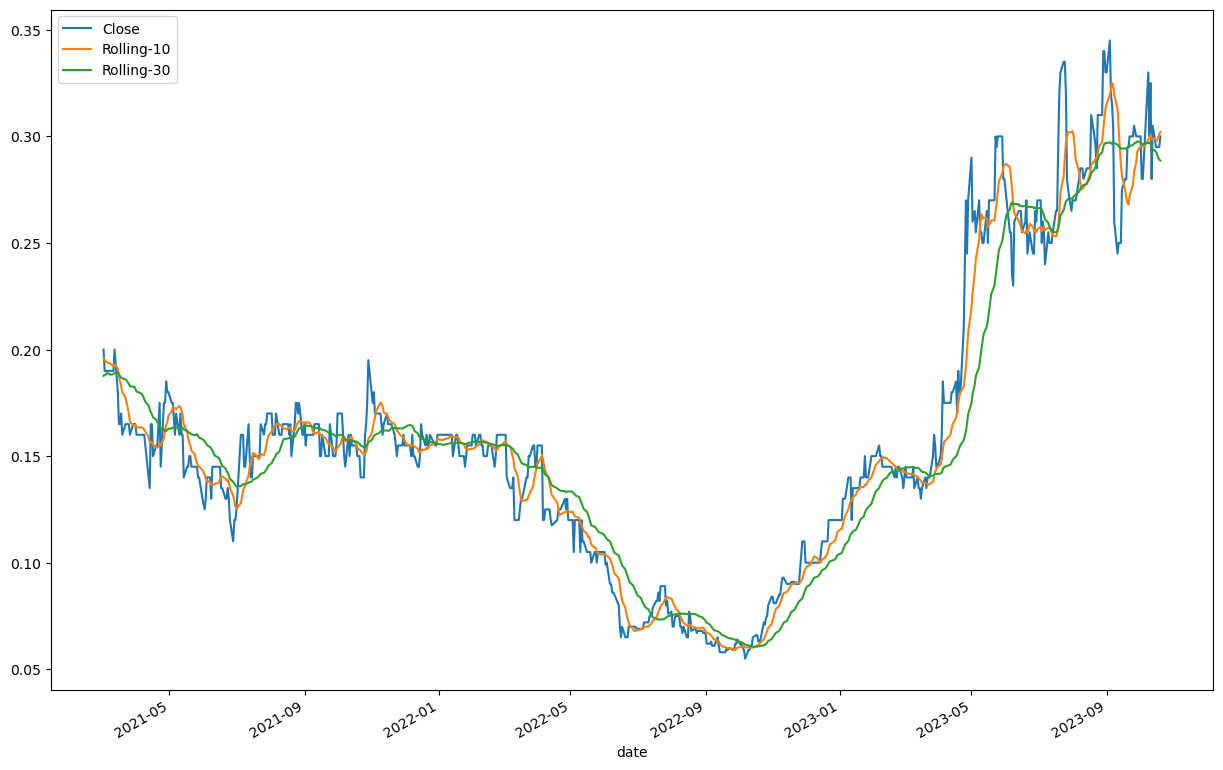

In [224]:
#df = df.set_index('date')
dummyprint = df[(df.share == "ODA")&(df.date_2 > '2021-03-01')] #WBC 
#_= dummyprint['Close'].plot(figsize=(15, 5))
dummyprint = dummyprint.set_index('date')
_= dummyprint[['Close','Rolling-10',  'Rolling-30']].plot(figsize=(15, 10))

In [225]:
Combo_Buy_Sell_Next[ (Combo_Buy_Sell_Next.share == "ODA")]

,share,date,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days
18757,ODA,2019-06-04,Buy,0.110,38428.0,38427.0,2019-08-28,Sell,0.160,0.050,1.454545,85 days,85.0,0.017112,3.764706
18758,ODA,2019-09-20,Buy,0.190,38430.0,38429.0,2019-11-18,Sell,0.225,0.035,1.184211,59 days,59.0,0.020071,4.415700
18759,ODA,2019-12-05,Buy,0.255,38432.0,38431.0,2019-12-06,Sell,0.245,-0.010,0.960784,1 days,1.0,0.960784,211.372549
18760,ODA,2020-06-10,Buy,0.110,38434.0,38433.0,2020-07-13,Sell,0.115,0.005,1.045455,33 days,33.0,0.031680,6.969697
18761,ODA,2020-10-16,Buy,0.165,38436.0,38435.0,2021-01-04,Sell,0.160,-0.005,0.969697,80 days,80.0,0.012121,2.666667
18762,ODA,2021-01-04,Sell,0.160,38437.0,38436.0,2021-03-16,Sell,0.165,0.005,1.031250,71 days,71.0,0.014525,3.195423
18763,ODA,2021-04-27,Buy,0.175,38439.0,38438.0,2021-05-17,Sell,0.145,-0.030,0.828571,20 days,20.0,0.041429,9.114286
18764,ODA,2021-10-07,Buy,0.150,38442.0,38441.0,2021-10-08,Sell,0.145,-0.005,0.966667,1 days,1.0,0.966667,212.666667
18765,ODA,2021-10-11,Buy,0.160,38444.0,38443.0,2021-10-18,Sell,0.155,-0.005,0.968750,7 days,7.0,0.138393,30.446429
18766,ODA,2021-10-29,Buy,0.195,38446.0,38445.0,2021-11-24,Sell,0.150,-0.045,0.769231,26 days,26.0,0.029586,6.508876


In [226]:
#Combo_Buy_Sell_Next.groupby(['ASX200'])['Change_Close_Ratio'].mean()

In [227]:
Combo_Buy_Sell_Next = Combo_Buy_Sell_Next.set_index('date')

In [228]:
bins_Close = np.array([0,0.1,0.5,1,1.5,2,2.5,3,4,5,10,15,20,25,50,150,])

In [229]:
Combo_Buy_Sell_Next["Close_Bucket"] = pd.cut(Combo_Buy_Sell_Next.Close, bins_Close)

In [230]:
Combo_Buy_Sell_Next.groupby(['Close_Bucket'])['Change_Close_Ratio'].mean()

Close_Bucket
(0.0, 0.1]       1.388544
(0.1, 0.5]       1.020909
(0.5, 1.0]       1.008763
(1.0, 1.5]       1.006757
(1.5, 2.0]       1.004279
(2.0, 2.5]       0.998664
(2.5, 3.0]       1.009645
(3.0, 4.0]       1.006171
(4.0, 5.0]       1.001624
(5.0, 10.0]      1.005504
(10.0, 15.0]     0.997353
(15.0, 20.0]     1.015364
(20.0, 25.0]     1.004905
(25.0, 50.0]     1.002656
(50.0, 150.0]    1.001401
Name: Change_Close_Ratio, dtype: float64

In [231]:
Combo_Buy_Sell_Next.sample(5)

,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket
date,,,,,,,,,,,,,,,
2023-01-13,PLT,Buy,0.490,41434.0,41433.0,2023-02-15,Sell,0.525,0.035,1.071429,33 days,33.0,0.032468,7.142857,"(0.1, 0.5]"
2021-08-30,CPV,Buy,0.370,13639.0,13638.0,2021-09-21,Sell,0.300,-0.070,0.810811,22 days,22.0,0.036855,8.108108,"(0.1, 0.5]"
2023-04-13,IHD,Buy,13.110,26452.0,26451.0,2023-05-05,Sell,12.750,-0.360,0.972540,22 days,22.0,0.044206,9.725400,"(10.0, 15.0]"
2022-04-01,WAT,Buy,3.470,56075.0,56074.0,2022-06-03,Sell,3.600,0.130,1.037464,63 days,63.0,0.016468,3.622890,"(3.0, 4.0]"
2019-11-07,TNG,Buy,0.091,52580.0,52579.0,2019-12-11,Sell,0.090,-0.001,0.989011,34 days,34.0,0.029089,6.399483,"(0.0, 0.1]"


In [232]:
Combo_Buy_Sell_Next.groupby(['Close_Bucket'])['Change_Close_Ratio'].count()

Close_Bucket
(0.0, 0.1]       5092
(0.1, 0.5]       7972
(0.5, 1.0]       3097
(1.0, 1.5]       2290
(1.5, 2.0]       1325
(2.0, 2.5]        939
(2.5, 3.0]        755
(3.0, 4.0]       1084
(4.0, 5.0]        833
(5.0, 10.0]      1545
(10.0, 15.0]      804
(15.0, 20.0]      443
(20.0, 25.0]      398
(25.0, 50.0]      841
(50.0, 150.0]     913
Name: Change_Close_Ratio, dtype: int64

In [233]:
Combo_Buy_Sell_Next= Combo_Buy_Sell_Next.reset_index()

In [234]:
Combo_Buy_Sell_Next = Combo_Buy_Sell_Next.merge(df_sharematch_ASX200, on = ['share'])

In [235]:
Combo_Buy_Sell_Next.groupby(['ASX200'])['Change_Close_Ratio'].mean()

ASX200
0.0    1.089200
1.0    1.012585
Name: Change_Close_Ratio, dtype: float64

In [236]:
Combo_Buy_Sell_Next.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0


In [237]:
Combo_Buy_Sell_Next.groupby(['Close_Bucket','ASX200'])['Change_Close_Ratio'].mean()

Close_Bucket   ASX200
(0.0, 0.1]     0.0       1.387551
               1.0       2.230347
(0.1, 0.5]     0.0       1.020465
               1.0       1.292790
(0.5, 1.0]     0.0       1.008062
               1.0       1.058530
(1.0, 1.5]     0.0       1.005909
               1.0       1.029320
(1.5, 2.0]     0.0       1.003615
               1.0       1.009768
(2.0, 2.5]     0.0       0.995698
               1.0       1.012682
(2.5, 3.0]     0.0       1.006957
               1.0       1.016527
(3.0, 4.0]     0.0       1.001575
               1.0       1.014617
(4.0, 5.0]     0.0       0.996375
               1.0       1.008386
(5.0, 10.0]    0.0       1.000718
               1.0       1.010224
(10.0, 15.0]   0.0       0.997370
               1.0       0.997340
(15.0, 20.0]   0.0       1.002156
               1.0       1.024071
(20.0, 25.0]   0.0       1.008003
               1.0       1.002214
(25.0, 50.0]   0.0       0.999941
               1.0       1.004863
(50.0, 150.0]  0.0       0

In [238]:
Combo_Buy_Sell_Next.groupby(['Close_Bucket','ASX200'])['Change_Close_Ratio'].count()

Close_Bucket   ASX200
(0.0, 0.1]     0.0       5086
               1.0          6
(0.1, 0.5]     0.0       7959
               1.0         13
(0.5, 1.0]     0.0       3054
               1.0         43
(1.0, 1.5]     0.0       2207
               1.0         83
(1.5, 2.0]     0.0       1182
               1.0        143
(2.0, 2.5]     0.0        775
               1.0        164
(2.5, 3.0]     0.0        543
               1.0        212
(3.0, 4.0]     0.0        702
               1.0        382
(4.0, 5.0]     0.0        469
               1.0        364
(5.0, 10.0]    0.0        767
               1.0        778
(10.0, 15.0]   0.0        342
               1.0        462
(15.0, 20.0]   0.0        176
               1.0        267
(20.0, 25.0]   0.0        185
               1.0        213
(25.0, 50.0]   0.0        377
               1.0        464
(50.0, 150.0]  0.0        537
               1.0        376
Name: Change_Close_Ratio, dtype: int64

In [239]:
bins_Ratio = np.array([0,0.5,0.75,0.9,0.95,1,1.05,1.1,1.5,2])
Combo_Buy_Sell_Next["Change_Close_Ratio_Bucket"] = pd.cut(Combo_Buy_Sell_Next.Change_Close_Ratio, bins_Ratio)

In [240]:
#Combo_Buy_Sell_Next.groupby(['Change_Close_Ratio_Bucket', 'Close_Bucket']).count()

In [241]:
bins_Profit_Binary = np.array([0,1,100])

In [242]:
Combo_Buy_Sell_Next["Change_Close_Up_Down"] = pd.cut(Combo_Buy_Sell_Next.Change_Close_Ratio, bins_Profit_Binary)

In [243]:
Combo_Buy_Sell_Next.groupby(['Change_Close_Up_Down'])['Change_Close_Ratio'].mean()

Change_Close_Up_Down
(0, 1]      0.920395
(1, 100]    1.332696
Name: Change_Close_Ratio, dtype: float64

# Matching Buy to Sell

In [391]:
#Combo_Buy_Sell_Next[(Combo_Buy_Sell_Next.share == "ODA")]

In [245]:
Combo_Buy_Sell_Next.shape

(28436, 19)

In [246]:
Combo_Buy_Sell_Next.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"


In [247]:
Combo_Buy_Sell_Next = Combo_Buy_Sell_Next.set_index('date')

In [248]:
#Combo_Buy_Sell_Next['Change_Close_Ratio'].resample('W').mean().plot()

In [249]:
#Combo_Buy_Sell_Next['Close'].resample('W').mean().plot()

In [250]:
#Combo_Buy_Sell_Next.groupby(['share','Change_Close_Up_Down'])['Change_Close_Ratio'].mean()

In [251]:
Combo_Buy_Sell_Next = Combo_Buy_Sell_Next.reset_index()

In [252]:
#Combo_2019_Jan_June = Combo_Buy_Sell_Next[Combo_Buy_Sell_Next.date < '2019-06-01']
Combo_Earlier = Combo_Buy_Sell_Next[Combo_Buy_Sell_Next.date < '2023-08-01']

In [253]:
Combo_Later = Combo_Buy_Sell_Next[Combo_Buy_Sell_Next.date > '2023-08-01']

In [254]:
Combo_Later = Combo_Later[Combo_Later.date > '2023-08-01']

In [255]:
#Combo_Buy_Sell_Next_2019_Jan_June.groupby(['share','Change_Close_Up_Down'])['Change_Close_Ratio'].mean()

In [256]:
Combo_Later.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
13,2023-08-17,14D,Buy,0.046,26.0,25.0,2023-08-22,Sell,0.042,-0.004,0.913043,5 days,5.0,0.182609,40.173913,"(0.0, 0.1]",0.0,"(0.9, 0.95]","(0, 1]"
101,2023-08-04,3PL,Buy,1.150,206.0,205.0,2023-08-21,Sell,1.100,-0.050,0.956522,17 days,17.0,0.056266,12.378517,"(1.0, 1.5]",0.0,"(0.95, 1.0]","(0, 1]"
102,2023-09-01,3PL,Buy,1.165,208.0,207.0,2023-10-20,Sell,1.190,0.025,1.021459,49 days,49.0,0.020846,4.586143,"(1.0, 1.5]",0.0,"(1.0, 1.05]","(1, 100]"
182,2023-09-13,8CO,Buy,0.083,375.0,374.0,2023-09-26,Sell,0.072,-0.011,0.867470,13 days,13.0,0.066728,14.680259,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"
196,2023-08-18,8IH,Buy,0.029,402.0,401.0,2023-09-05,Sell,0.026,-0.003,0.896552,18 days,18.0,0.049808,10.957854,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"


In [257]:
Combo_Earlier.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"


In [258]:
Combo_Earlier_Profit= Combo_Earlier[Combo_Earlier.Change_Close_Ratio > 1]

In [259]:
Combo_Earlier_Profit.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.1450,0.0300,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.1800,0.0500,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.2250,0.0450,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
9,2022-06-29,14D,Buy,0.077,18.0,17.0,2022-08-16,Sell,0.0880,0.0110,1.142857,48 days,48.0,0.023810,5.238095,"(0.0, 0.1]",0.0,"(1.1, 1.5]","(1, 100]"
12,2023-05-12,14D,Buy,0.062,24.0,23.0,2023-05-31,Sell,0.0645,0.0025,1.040323,19 days,19.0,0.054754,12.045840,"(0.0, 0.1]",0.0,"(1.0, 1.05]","(1, 100]"


In [260]:
Combo_Earlier_Profit[Combo_Earlier_Profit.share=='A2B']

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
259,2020-05-04,A2B,Buy,0.715,535.0,534.0,2020-07-02,Sell,0.795,0.080,1.111888,59 days,59.0,0.018846,4.146023,"(0.5, 1.0]",0.0,"(1.1, 1.5]","(1, 100]"
260,2020-08-20,A2B,Buy,0.920,537.0,536.0,2020-10-13,Sell,1.070,0.150,1.163043,54 days,54.0,0.021538,4.738325,"(0.5, 1.0]",0.0,"(1.1, 1.5]","(1, 100]"
261,2020-11-17,A2B,Buy,1.110,539.0,538.0,2020-12-24,Sell,1.210,0.100,1.090090,37 days,37.0,0.029462,6.481617,"(1.0, 1.5]",0.0,"(1.05, 1.1]","(1, 100]"
263,2021-03-24,A2B,Buy,1.160,543.0,542.0,2021-05-27,Sell,1.260,0.100,1.086207,64 days,64.0,0.016972,3.733836,"(1.0, 1.5]",0.0,"(1.05, 1.1]","(1, 100]"
272,2022-07-04,A2B,Buy,1.090,561.0,560.0,2022-09-27,Sell,1.165,0.075,1.068807,85 days,85.0,0.012574,2.766325,"(1.0, 1.5]",0.0,"(1.05, 1.1]","(1, 100]"
273,2023-01-18,A2B,Buy,1.060,564.0,563.0,2023-05-17,Sell,1.470,0.410,1.386792,119 days,119.0,0.011654,2.563818,"(1.0, 1.5]",0.0,"(1.1, 1.5]","(1, 100]"
274,2023-06-28,A2B,Buy,1.560,566.0,565.0,2023-08-31,Sell,1.600,0.040,1.025641,64 days,64.0,0.016026,3.525641,"(1.5, 2.0]",0.0,"(1.0, 1.05]","(1, 100]"


In [261]:
Combo_Earlier_Loss=Combo_Earlier[Combo_Earlier.Change_Close_Ratio < 1]

In [262]:
Combo_Earlier_Loss.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
6,2021-10-15,14D,Buy,0.125,12.0,11.0,2021-11-17,Sell,0.120,-0.005,0.960000,33 days,33.0,0.029091,6.400000,"(0.1, 0.5]",0.0,"(0.95, 1.0]","(0, 1]"
7,2022-01-20,14D,Buy,0.120,14.0,13.0,2022-02-09,Sell,0.105,-0.015,0.875000,20 days,20.0,0.043750,9.625000,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
8,2022-03-23,14D,Buy,0.100,16.0,15.0,2022-03-29,Sell,0.096,-0.004,0.960000,6 days,6.0,0.160000,35.200000,"(0.0, 0.1]",0.0,"(0.95, 1.0]","(0, 1]"


In [263]:
Combo_Earlier_Loss[Combo_Earlier_Loss.share=='A2M']

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
280,2020-03-26,A2M,Buy,16.00,579.0,578.0,2020-03-27,Sell,15.87,-0.13,0.991875,1 days,1.0,0.991875,218.212500,"(15.0, 20.0]",1.0,"(0.95, 1.0]","(0, 1]"
282,2020-06-18,A2M,Buy,19.39,583.0,582.0,2020-08-25,Sell,18.18,-1.21,0.937597,68 days,68.0,0.013788,3.033401,"(15.0, 20.0]",1.0,"(0.9, 0.95]","(0, 1]"
283,2020-11-19,A2M,Buy,13.80,585.0,584.0,2020-11-25,Sell,13.75,-0.05,0.996377,6 days,6.0,0.166063,36.533816,"(10.0, 15.0]",1.0,"(0.95, 1.0]","(0, 1]"
284,2021-06-17,A2M,Buy,5.96,587.0,586.0,2021-07-30,Sell,5.86,-0.10,0.983221,43 days,43.0,0.022866,5.030435,"(5.0, 10.0]",1.0,"(0.95, 1.0]","(0, 1]"
285,2021-08-25,A2M,Buy,6.86,589.0,588.0,2021-09-03,Sell,5.73,-1.13,0.835277,9 days,9.0,0.092809,20.417881,"(5.0, 10.0]",1.0,"(0.75, 0.9]","(0, 1]"
287,2022-02-21,A2M,Buy,5.89,593.0,592.0,2022-03-14,Sell,5.19,-0.70,0.881154,21 days,21.0,0.041960,9.231142,"(5.0, 10.0]",1.0,"(0.75, 0.9]","(0, 1]"
288,2022-05-31,A2M,Buy,4.80,595.0,594.0,2022-06-21,Sell,4.29,-0.51,0.893750,21 days,21.0,0.042560,9.363095,"(4.0, 5.0]",1.0,"(0.75, 0.9]","(0, 1]"
289,2022-07-06,A2M,Buy,4.55,597.0,596.0,2022-07-28,Sell,4.40,-0.15,0.967033,22 days,22.0,0.043956,9.670330,"(4.0, 5.0]",1.0,"(0.95, 1.0]","(0, 1]"
292,2023-07-17,A2M,Buy,5.17,603.0,602.0,2023-08-14,Sell,4.95,-0.22,0.957447,28 days,28.0,0.034195,7.522796,"(5.0, 10.0]",1.0,"(0.95, 1.0]","(0, 1]"


In [264]:
Combo_Earlier_Profit.groupby(['Change_Close_Up_Down'])['Change_Close_Ratio'].mean()

Change_Close_Up_Down
(0, 1]           NaN
(1, 100]    1.335596
Name: Change_Close_Ratio, dtype: float64

In [265]:
Combo_Earlier.groupby(['Change_Close_Up_Down'])['Change_Close_Ratio'].count()

Change_Close_Up_Down
(0, 1]      18937
(1, 100]     8685
Name: Change_Close_Ratio, dtype: int64

In [266]:
# Can do counts of profits and counts of losses to exclude

In [267]:
#Combo_Buy_Sell_Next_2019_Jan_June_Profit.head()

In [268]:
Combo_Earlier_Profit_Shares = Combo_Earlier_Profit.groupby(['share'])['Change_Close_Ratio'].mean()

In [269]:
#Combo_Jan_June_Profit_Shares.head()

In [270]:
#type(Combo_Jan_June_Profit_Shares)

In [271]:
Combo_Earlier_Profit_Shares  = pd.DataFrame(Combo_Earlier_Profit_Shares)

In [272]:
Combo_Earlier_Profit_Shares  = Combo_Earlier_Profit_Shares.reset_index()

In [273]:
Combo_Earlier_Profit_Shares.head()

,share,Change_Close_Ratio
0,14D,1.215733
1,1AD,1.265392
2,3DA,1.911905
3,3DP,2.413512
4,3PL,1.190155


In [274]:
#Combo_Earlier_Profit_Limit= Combo_Earlier_Profit_Limit[Combo_Buy_Sell_Next_2019_Jan_June_Profit_Limit.Change_Close_Ratio > 1]

In [275]:
#Combo_Buy_Sell_Next_2019_July_Dec.groupby(['Change_Close_Up_Down'])['Change_Close_Ratio'].mean()

In [276]:
#Combo_Jan_June_Profit_Shares['Change_Close_Ratio'].mean()

In [277]:
Combo_Earlier_Profit_Shares.head()

,share,Change_Close_Ratio
0,14D,1.215733
1,1AD,1.265392
2,3DA,1.911905
3,3DP,2.413512
4,3PL,1.190155


In [278]:
Combo_Later.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
13,2023-08-17,14D,Buy,0.046,26.0,25.0,2023-08-22,Sell,0.042,-0.004,0.913043,5 days,5.0,0.182609,40.173913,"(0.0, 0.1]",0.0,"(0.9, 0.95]","(0, 1]"
101,2023-08-04,3PL,Buy,1.150,206.0,205.0,2023-08-21,Sell,1.100,-0.050,0.956522,17 days,17.0,0.056266,12.378517,"(1.0, 1.5]",0.0,"(0.95, 1.0]","(0, 1]"
102,2023-09-01,3PL,Buy,1.165,208.0,207.0,2023-10-20,Sell,1.190,0.025,1.021459,49 days,49.0,0.020846,4.586143,"(1.0, 1.5]",0.0,"(1.0, 1.05]","(1, 100]"
182,2023-09-13,8CO,Buy,0.083,375.0,374.0,2023-09-26,Sell,0.072,-0.011,0.867470,13 days,13.0,0.066728,14.680259,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"
196,2023-08-18,8IH,Buy,0.029,402.0,401.0,2023-09-05,Sell,0.026,-0.003,0.896552,18 days,18.0,0.049808,10.957854,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"


In [279]:
Combo_Earlier_Profit_Shares =Combo_Earlier_Profit_Shares.drop(['Change_Close_Ratio'],axis=1)

In [280]:
# Where shares had a profit making in Jan to June and possibly also a loss making

Combo_Later_OptionA1 = Combo_Later.merge(Combo_Earlier_Profit_Shares, on = ['share'], how = 'inner')

In [281]:
Combo_Later_OptionA1.head() 

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2023-08-17,14D,Buy,0.046,26.0,25.0,2023-08-22,Sell,0.042,-0.004,0.913043,5 days,5.0,0.182609,40.173913,"(0.0, 0.1]",0.0,"(0.9, 0.95]","(0, 1]"
1,2023-08-04,3PL,Buy,1.150,206.0,205.0,2023-08-21,Sell,1.100,-0.050,0.956522,17 days,17.0,0.056266,12.378517,"(1.0, 1.5]",0.0,"(0.95, 1.0]","(0, 1]"
2,2023-09-01,3PL,Buy,1.165,208.0,207.0,2023-10-20,Sell,1.190,0.025,1.021459,49 days,49.0,0.020846,4.586143,"(1.0, 1.5]",0.0,"(1.0, 1.05]","(1, 100]"
3,2023-09-13,8CO,Buy,0.083,375.0,374.0,2023-09-26,Sell,0.072,-0.011,0.867470,13 days,13.0,0.066728,14.680259,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"
4,2023-08-18,8IH,Buy,0.029,402.0,401.0,2023-09-05,Sell,0.026,-0.003,0.896552,18 days,18.0,0.049808,10.957854,"(0.0, 0.1]",0.0,"(0.75, 0.9]","(0, 1]"


In [282]:
# Benchmark
Combo_Later['Change_Close_Ratio'].mean()

0.936520857773327

In [283]:
# Where shares had a profit making in earlier and possibly also a loss making
Combo_Later_OptionA1['Change_Close_Ratio'].mean()

0.9369979831623888

In [284]:
Combo_Earlier_Loss_Shares = Combo_Earlier_Loss.groupby(['share'])['Change_Close_Ratio'].mean()

In [285]:
Combo_Earlier_Loss_Shares = pd.DataFrame(Combo_Earlier_Loss_Shares)

In [286]:
Combo_Earlier_Loss_Shares.head()

,Change_Close_Ratio
share,
14D,0.891494
1AD,0.900881
2BE,0.839378
3DA,0.895650
3DP,0.885079


In [287]:
Combo_Earlier_Loss_Shares = Combo_Earlier_Loss_Shares.reset_index()

In [288]:
Combo_Earlier_Loss_Shares =Combo_Earlier_Loss_Shares.drop(['Change_Close_Ratio'],axis=1)

In [289]:
Combo_Earlier_Loss_Shares.head()

,share
0,14D
1,1AD
2,2BE
3,3DA
4,3DP


In [290]:
Combo_Earlier_Profit_Only_Shares = pd.concat([Combo_Earlier_Profit_Shares,Combo_Earlier_Loss_Shares]).drop_duplicates()

In [291]:
Combo_Earlier_Profit_Only_Shares.head()

,share
0,14D
1,1AD
2,3DA
3,3DP
4,3PL


In [292]:
#Combo_2019_Jan_June_Profit_Limit_2 = Combo_2019_Jan_June_Profit_Limit.copy()

In [293]:
#Combo_2019_Jan_June_Profit_Limit= Combo_Buy_Sell_Next_2019_Jan_June_Profit_Limit[Combo_Buy_Sell_Next_2019_Jan_June_Profit_Limit.Change_Close_Ratio > 1]

In [294]:
Combo_Earlier_Loss.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
6,2021-10-15,14D,Buy,0.125,12.0,11.0,2021-11-17,Sell,0.120,-0.005,0.960000,33 days,33.0,0.029091,6.400000,"(0.1, 0.5]",0.0,"(0.95, 1.0]","(0, 1]"
7,2022-01-20,14D,Buy,0.120,14.0,13.0,2022-02-09,Sell,0.105,-0.015,0.875000,20 days,20.0,0.043750,9.625000,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
8,2022-03-23,14D,Buy,0.100,16.0,15.0,2022-03-29,Sell,0.096,-0.004,0.960000,6 days,6.0,0.160000,35.200000,"(0.0, 0.1]",0.0,"(0.95, 1.0]","(0, 1]"


In [295]:
Combo_Earlier_Loss_Shares = Combo_Earlier_Loss.groupby(['share'])['Change_Close_Ratio'].mean()

In [296]:
Combo_Earlier_Loss_Shares.head()

share
14D    0.891494
1AD    0.900881
2BE    0.839378
3DA    0.895650
3DP    0.885079
Name: Change_Close_Ratio, dtype: float64

In [297]:
Combo_Earlier_Loss_Shares = pd.DataFrame(Combo_Earlier_Loss_Shares)

In [298]:
Combo_Earlier_Loss_Shares = Combo_Earlier_Loss_Shares.reset_index()

In [299]:
Combo_Earlier_Loss_Shares.head()

,share,Change_Close_Ratio
0,14D,0.891494
1,1AD,0.900881
2,2BE,0.839378
3,3DA,0.895650
4,3DP,0.885079


In [300]:
Combo_Earlier_Loss_Shares = Combo_Earlier_Loss_Shares.drop(['Change_Close_Ratio'],axis=1)

In [301]:
Combo_Earlier_Loss_Shares.head()

,share
0,14D
1,1AD
2,2BE
3,3DA
4,3DP


In [302]:
Combo_Earlier_Profit_Shares.head()

,share
0,14D
1,1AD
2,3DA
3,3DP
4,3PL


In [303]:
type(Combo_Earlier_Profit_Shares)

pandas.core.frame.DataFrame

In [304]:
#Combo_Jan_June_shares = Combo_2019_Jan_June_Profit_Limit.drop(['index','Change_Close_Ratio' ],axis=1)

In [305]:
Combo_Earlier_Profit_Shares.head()

,share
0,14D
1,1AD
2,3DA
3,3DP
4,3PL


In [306]:
Combo_Earlier_Profit_Limit_2 = pd.concat([Combo_Earlier_Profit_Shares,Combo_Earlier_Loss_Shares]).drop_duplicates(keep=False)

In [307]:
Combo_Earlier_Profit_Limit_2.tail()

,share
1109,PNL
1148,PYR
1199,RGI
1274,SIL
1321,SRJ


In [308]:
Combo_Earlier_Profit_Limit_2[Combo_Earlier_Profit_Limit_2.share=='WSP']

,share


In [309]:
Combo_Earlier_Profit_Limit_2= Combo_Earlier_Profit_Limit_2.dropna()

In [310]:
#Combo_2019_Jan_June_Profit_Limit_2 = Combo_2019_Jan_June_Profit_Limit_2.drop(['level_0'],axis=1)

In [311]:
Combo_Earlier_Profit_Limit_2.head()

,share
214,BGP
727,ISX
1330,SVS
2,2BE
57,AGC


In [312]:
# Only Profit and no loss making 
Combo_Later_OptionB1 = Combo_Later.merge(Combo_Earlier_Profit_Limit_2, on = ['share'], how = 'inner')

In [313]:
Combo_Later_OptionB1.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2023-08-14,AGC,Buy,0.058,2165.0,2164.0,2023-10-13,Sell,0.060,0.002,1.034483,60 days,60.0,0.017241,3.793103,"(0.0, 0.1]",0.0,"(1.0, 1.05]","(1, 100]"
1,2023-08-14,BNZ,Buy,0.400,8989.0,8988.0,2023-08-17,Sell,0.425,0.025,1.062500,3 days,3.0,0.354167,77.916667,"(0.1, 0.5]",0.0,"(1.05, 1.1]","(1, 100]"
2,2023-09-08,BNZ,Buy,0.490,8991.0,8990.0,2023-10-04,Sell,0.360,-0.130,0.734694,26 days,26.0,0.028257,6.216641,"(0.1, 0.5]",0.0,"(0.5, 0.75]","(0, 1]"
3,2023-08-31,BPM,Buy,0.086,9249.0,9248.0,2023-09-29,Sell,0.084,-0.002,0.976744,29 days,29.0,0.033681,7.409783,"(0.0, 0.1]",0.0,"(0.95, 1.0]","(0, 1]"
4,2023-09-04,CCR,Buy,0.225,11129.0,11128.0,2023-09-22,Sell,0.190,-0.035,0.844444,18 days,18.0,0.046914,10.320988,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"


In [314]:
# Only Profit and no loss making 
Combo_Later_OptionB1['Change_Close_Ratio'].mean()

0.8899414916661667

In [315]:
Combo_Later_OptionB1['Ratio_220_Days'].mean()

15.581284891396912

In [316]:
# Benchmark
Combo_Later['Change_Close_Ratio'].mean()

0.936520857773327

In [317]:
Combo_Later['Ratio_220_Days'].mean()

32.56285099187449

In [318]:
# Where shares had a profit making in Jan to June and possibly also a loss making
Combo_Later_OptionA1['Change_Close_Ratio'].mean()

0.9369979831623888

In [319]:
Combo_Later_OptionA1['Ratio_220_Days'].mean()

32.73679789175134

# Individual Share

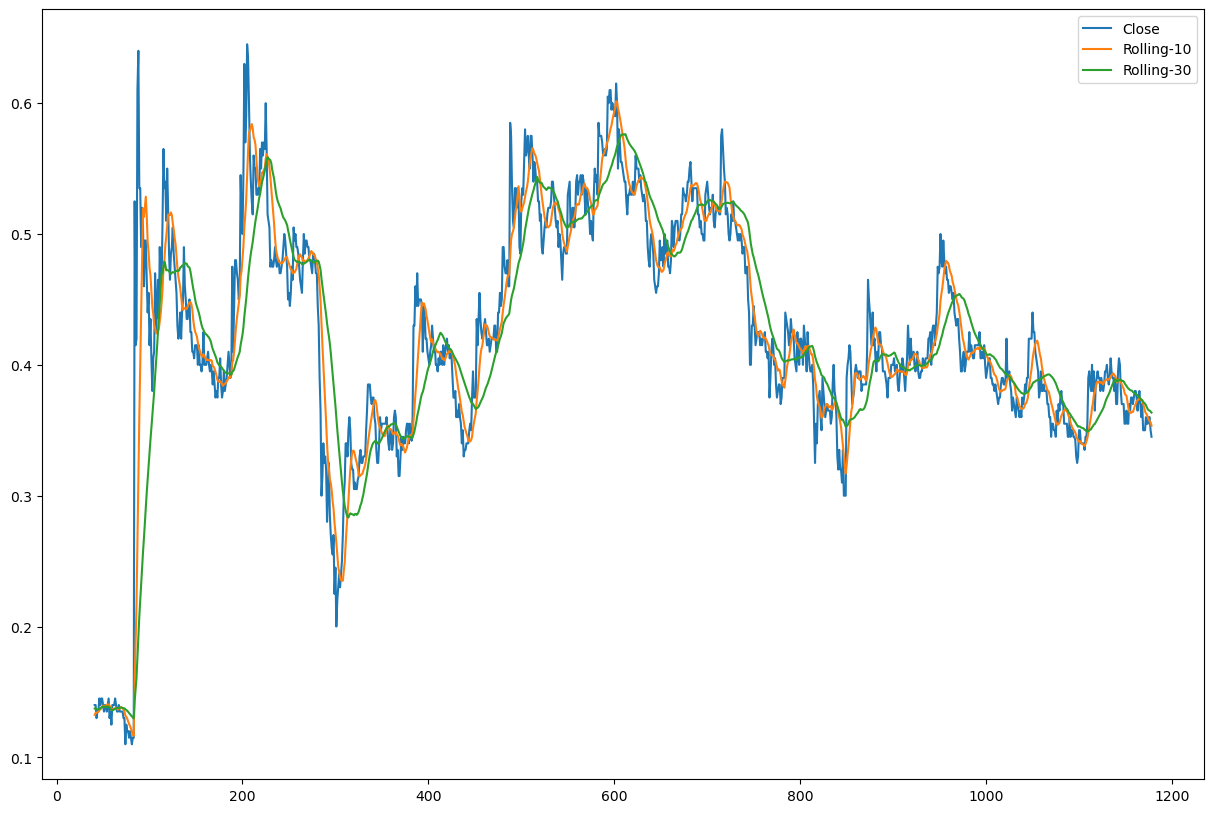

In [320]:
#df = df.set_index('date')
dummyprint = df[(df.share == "OCC")&(df.date_2 > '2019-03-01')] #WBC
#_= dummyprint['Close'].plot(figsize=(15, 5))
_= dummyprint[['Close','Rolling-10',  'Rolling-30']].plot(figsize=(15, 10)) # , 'Rolling-5''Rolling-15',

In [321]:
#ind_new_df= new_df[new_df.share == 'IVC']

In [322]:
ind_new_df= df[df.share == 'OCC']

In [323]:
#ind_new_df.info()

# Next


In [324]:
#ind_new_df.info()

In [325]:
ind_new_df.head()

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket,Buy_Cross_10_30,Sell_Cross_10_30
0,2019-01-02,685764,OCC,0.155,0.155,0.155,0.155,25000,2019-01-02,0.0,...,2019-01-02,False,False,NaN,NaN,NaN,NaN,NaN,0,0
1,2019-01-03,685765,OCC,0.155,0.155,0.155,0.155,5000,2019-01-03,0.0,...,2019-01-03,False,False,NaN,NaN,NaN,NaN,NaN,0,0
2,2019-01-04,685766,OCC,0.160,0.160,0.150,0.150,8779,2019-01-04,0.0,...,2019-01-04,False,False,NaN,NaN,NaN,NaN,NaN,0,0
3,2019-01-07,685767,OCC,0.155,0.155,0.150,0.150,16273,2019-01-07,0.0,...,2019-01-07,False,False,NaN,NaN,NaN,NaN,NaN,0,0
4,2019-01-08,685768,OCC,0.150,0.160,0.150,0.150,65111,2019-01-08,0.0,...,2019-01-08,False,False,NaN,NaN,NaN,NaN,NaN,0,0


In [326]:
ind_new_df.groupby(['Buy-Rolling-10-30-Cross'])['Compare_F3_rat','Compare_F7_rat','Compare_F14_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\2487778782.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Compare_F3_rat,Compare_F7_rat,Compare_F14_rat
Buy-Rolling-10-30-Cross,,,
False,1.008508,1.022326,1.040440
True,0.999949,0.982688,0.991039


In [327]:
new_df.head()

""


In [328]:
ind_new_df.groupby(['Buy-Rolling-10-30-Cross'])['Compare_F14_rat'].mean()

Buy-Rolling-10-30-Cross
False    1.040440
True     0.991039
Name: Compare_F14_rat, dtype: float64

In [329]:
df.groupby(['Buy-Rolling-10-30-Cross'])['Compare_F14_rat'].mean()

Buy-Rolling-10-30-Cross
False    1.043610
True     1.046057
Name: Compare_F14_rat, dtype: float64

In [330]:
df.groupby(['Buy_Cross_10_30'])['Compare_F3_rat','Compare_F7_rat','Compare_F14_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\1843491840.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Compare_F3_rat,Compare_F7_rat,Compare_F14_rat
Buy_Cross_10_30,,,
0,1.009659,1.022085,1.043610
1,1.003925,1.024501,1.046057


In [331]:
df.groupby(['ASX200','Buy_Cross_10_30'])['Compare_F3_rat','Compare_F7_rat','Compare_F14_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\3787953113.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Compare_F3_rat  Compare_F7_rat  Compare_F14_rat
ASX200 Buy_Cross_10_30                                                 
0.0    0                      1.010985        1.025106         1.049545
       1                      1.004214        1.027434         1.052278
1.0    0                      1.001324        1.003095         1.006332
       1                      1.002175        1.006768         1.008508

In [332]:
#new_df.info()

# Graphs

In [333]:
Combo_Buy_Sell_Next.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28436 entries, 0 to 28435
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   date                       28436 non-null  datetime64[ns] 
 1   share                      28436 non-null  object         
 2   Option                     28436 non-null  object         
 3   Close                      28436 non-null  float64        
 4   order                      28436 non-null  float64        
 5   order_minus_one            28436 non-null  float64        
 6   sell_date                  28436 non-null  datetime64[ns] 
 7   Option_Sell                28436 non-null  object         
 8   Close_Sell                 28436 non-null  float64        
 9   Change_Close               28436 non-null  float64        
 10  Change_Close_Ratio         28436 non-null  float64        
 11  Days_between               28436 non-null  timedelta64

In [334]:
#Combo_Buy_Sell_Next = Combo_Buy_Sell_Next.set_index('date')

In [335]:
#Combo_Buy_Sell_Next['Close'].resample('W').mean().plot()

In [336]:
Combo_Buy_Sell_Next_limit_1= Combo_Buy_Sell_Next[Combo_Buy_Sell_Next['Close'] > 1]

In [337]:
Combo_Buy_Sell_Next_limit_1= Combo_Buy_Sell_Next[Combo_Buy_Sell_Next['Close'] < 40]

<Axes: xlabel='Days_between2', ylabel='Change_Close_Ratio'>

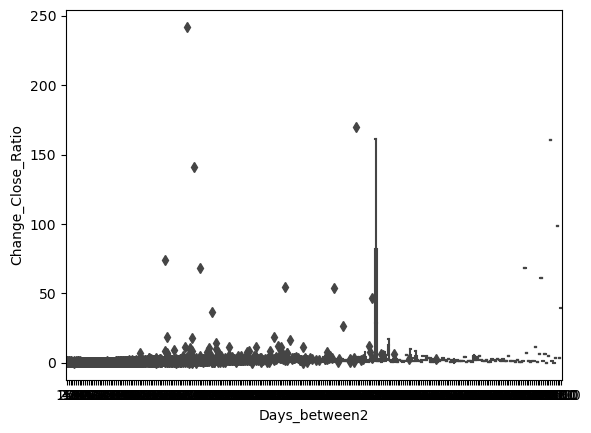

In [338]:
sns.boxplot(x="Days_between2", y="Change_Close_Ratio", data=Combo_Buy_Sell_Next)

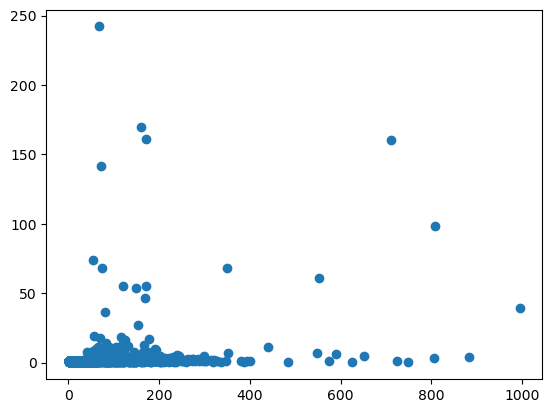

In [339]:
plt.scatter(Combo_Buy_Sell_Next_limit_1['Days_between2'], Combo_Buy_Sell_Next_limit_1['Change_Close_Ratio']) 

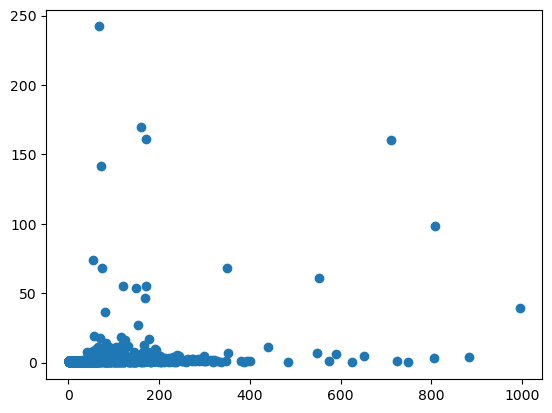

In [340]:
plt.scatter(Combo_Buy_Sell_Next['Days_between2'], Combo_Buy_Sell_Next['Change_Close_Ratio']) 

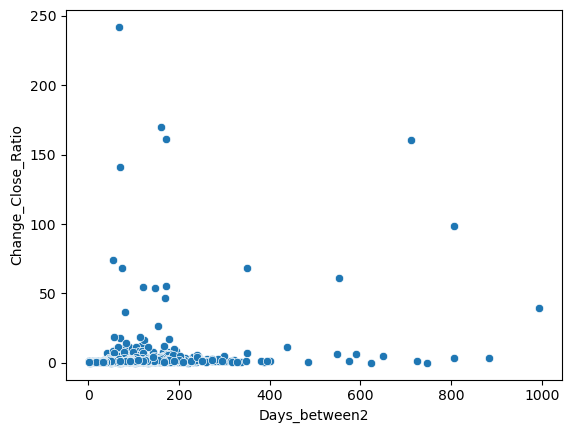

In [341]:
ax = sns.scatterplot(x="Days_between2", y="Change_Close_Ratio", data=Combo_Buy_Sell_Next_limit_1)

# Below is Very Good 

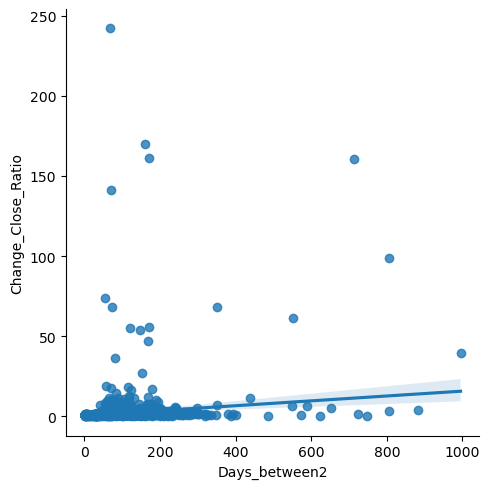

In [342]:
ax = sns.lmplot(x="Days_between2", y="Change_Close_Ratio", data=Combo_Buy_Sell_Next_limit_1)

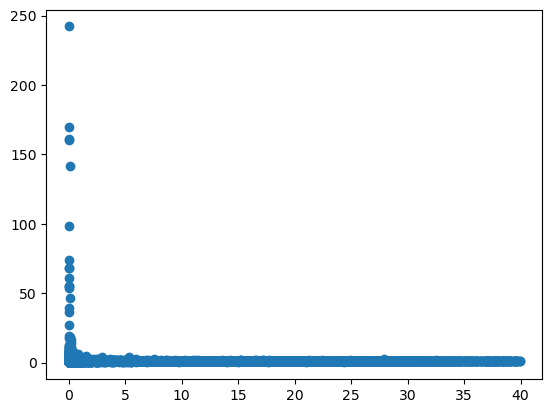

In [343]:
plt.scatter(Combo_Buy_Sell_Next_limit_1['Close'], Combo_Buy_Sell_Next_limit_1['Change_Close_Ratio']) 

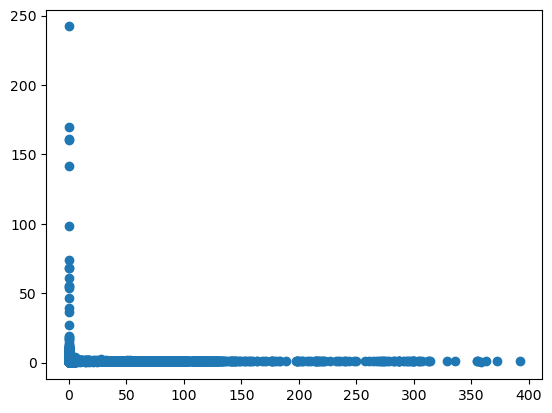

In [344]:
plt.scatter(Combo_Buy_Sell_Next['Close'], Combo_Buy_Sell_Next['Change_Close_Ratio']) 

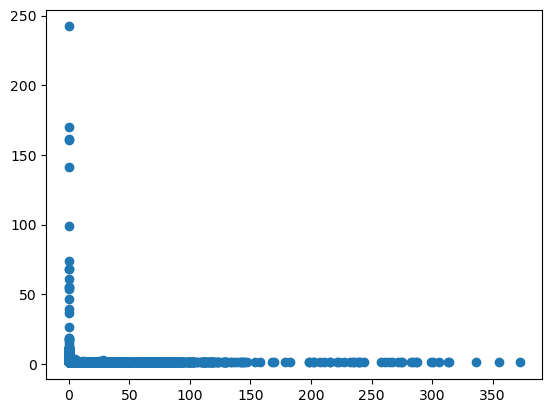

In [345]:
plt.scatter(Combo_Buy_Sell_Next['Close'][Combo_Buy_Sell_Next.Change_Close_Ratio > 1] , Combo_Buy_Sell_Next['Change_Close_Ratio'][Combo_Buy_Sell_Next.Change_Close_Ratio > 1]) 

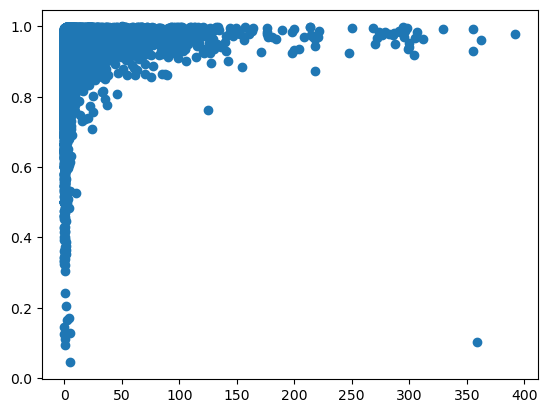

In [346]:
plt.scatter(Combo_Buy_Sell_Next['Close'][Combo_Buy_Sell_Next.Change_Close_Ratio < 1] , Combo_Buy_Sell_Next['Change_Close_Ratio'][Combo_Buy_Sell_Next.Change_Close_Ratio < 1])

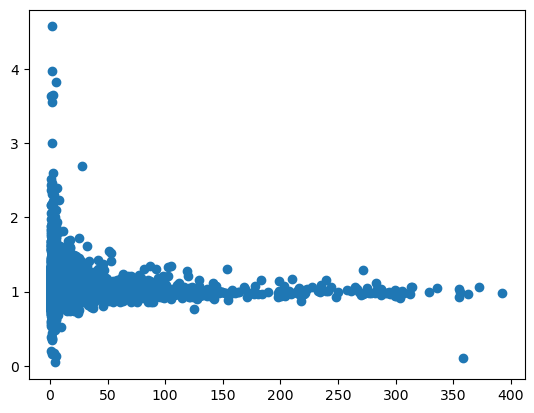

In [347]:
plt.scatter(Combo_Buy_Sell_Next['Close'][Combo_Buy_Sell_Next.Close >1], Combo_Buy_Sell_Next['Change_Close_Ratio'][Combo_Buy_Sell_Next.Close >1],) 

In [348]:
Combo_Buy_Sell_Next['Close'][(Combo_Buy_Sell_Next.Close >1)&(Combo_Buy_Sell_Next.Close <100)]

77       1.100
78       1.050
86       1.360
87       1.350
88       1.225
         ...  
28398    1.030
28399    3.050
28400    1.700
28424    2.040
28425    1.740
Name: Close, Length: 11994, dtype: float64

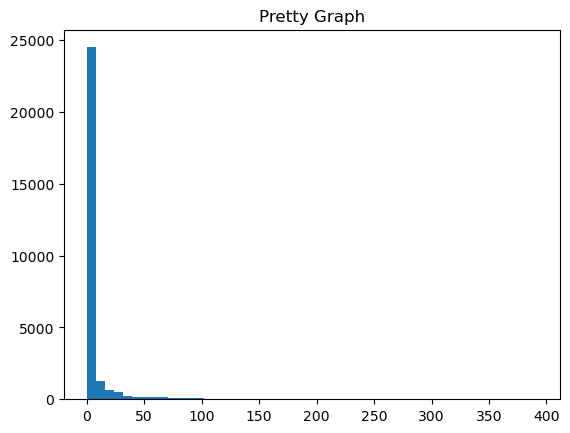

In [349]:
num_bins = 50
plt.title('Pretty Graph')
plt.hist(Combo_Buy_Sell_Next['Close'], bins =num_bins)
plt.show()

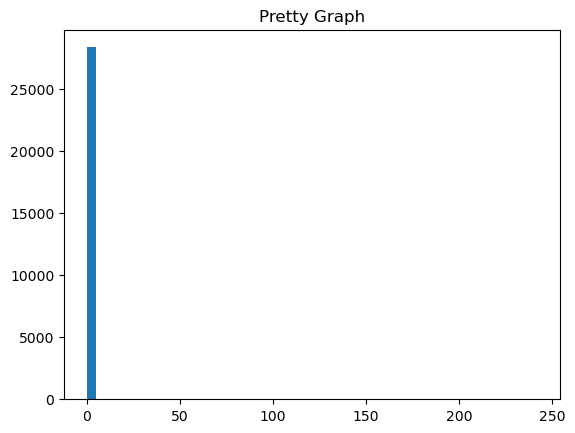

In [350]:
num_bins = 50
plt.title('Pretty Graph')
plt.hist(Combo_Buy_Sell_Next['Change_Close_Ratio'], bins =num_bins)
plt.show()

In [351]:
Combo_Buy_Sell_Next.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"


# Check Individual Shares

In [352]:
dummyDataDf= df[['share','date_2','Close','Rolling-10','Rolling-30']][(df.share == "COE")&(df.date_2 > '2019-03-01')]

In [353]:
dummyDataDf.head()

,share,date_2,Close,Rolling-10,Rolling-30
42,COE,2019-03-04,0.515,0.5165,0.491167
43,COE,2019-03-05,0.510,0.5170,0.493000
44,COE,2019-03-06,0.515,0.5165,0.494833
45,COE,2019-03-07,0.500,0.5155,0.496667
46,COE,2019-03-08,0.480,0.5115,0.497500


# Graphs of Comparisons

In [354]:
#df['share'].value_counts()

In [355]:
df.sample(5)

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket,Buy_Cross_10_30,Sell_Cross_10_30
1177,2023-10-16,787859,QUB,2.760,2.770,2.720,2.730,1200481,2023-10-16,1.0,...,2023-10-16,False,False,2.8100,0.995018,2.910667,0.996106,"(0.995, 1.0]",0,0
274,2020-02-07,1019953,WHK,0.072,0.076,0.072,0.076,210810,2020-02-07,0.0,...,2020-02-07,False,False,0.0744,0.995968,0.080900,0.995880,"(0.995, 1.0]",0,0
663,2022-02-25,182972,BUX,0.084,0.110,0.081,0.105,1411031,2022-02-25,0.0,...,2022-02-25,False,False,0.0961,0.989594,0.086600,1.013087,"(0.98, 0.99]",0,0
30,2019-02-19,116411,AUT,0.008,0.008,0.008,0.008,1065809,2019-02-19,0.0,...,2019-02-19,False,False,0.0062,1.048387,0.005400,1.018519,"(1.0, 1.05]",0,0
177,2021-01-20,1326273,AIV,0.130,0.130,0.130,0.130,0,2021-01-20,0.0,...,2021-01-20,False,False,0.1340,1.000000,0.132333,0.993703,"(0.995, 1.0]",0,0


In [356]:
#new_df.info()

In [357]:
#df.groupby(['share','Buy_Cross_10_30'])['Compare_F1', 'Compare_F7', 'Compare_F14', 'Compare_F21', 'Compare_F28', 'Compare_F60'].mean()

In [358]:
df.groupby(['Buy_Cross_10_30','ASX200'])['Compare_F1', 'Compare_F7', 'Compare_F14', 'Compare_F21', 'Compare_F28', 'Compare_F60'].mean()


C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\2121068726.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Compare_F1  Compare_F7  Compare_F14  Compare_F21  \
Buy_Cross_10_30 ASX200                                                     
0               0.0       0.000153    0.001141     0.001862     0.002864   
                1.0       0.005334    0.037886     0.074749     0.112472   
1               0.0      -0.000015    0.002658     0.009083     0.008683   
                1.0       0.010810    0.111380     0.151542     0.206659   

                        Compare_F28  Compare_F60  
Buy_Cross_10_30 ASX200                            
0               0.0        0.003880     0.008283  
                1.0        0.152913     0.332647  
1               0.0        0.010550    -0.020557  
                1.0        0.197189     0.248713

In [359]:
df.groupby(['Buy_Cross_10_30','ASX200'])['Compare_F1_rat', 'Compare_F7_rat', 'Compare_F14_rat', 'Compare_F21_rat', 'Compare_F28_rat', 'Compare_F60_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\2745375436.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Compare_F1_rat  Compare_F7_rat  Compare_F14_rat  \
Buy_Cross_10_30 ASX200                                                    
0               0.0           1.003815        1.025106         1.049545   
                1.0           1.000442        1.003095         1.006332   
1               0.0           1.003006        1.027434         1.052278   
                1.0           1.000812        1.006768         1.008508   

                        Compare_F21_rat  Compare_F28_rat  Compare_F60_rat  
Buy_Cross_10_30 ASX200                                                     
0               0.0            1.073573         1.097721         1.205479  
                1.0            1.009531         1.012724         1.027020  
1               0.0            1.071918         1.081964         1.156080  
                1.0            1.012136         1.015023         1.018449

In [360]:
#new_df.groupby(['share','Buy_Cross_5_20'])['Compare_F1_rat', 'Compare_F7_rat', 'Compare_F14_rat', 'Compare_F21_rat', 'Compare_F28_rat', 'Compare_F60_rat'].mean()

In [361]:
df.groupby([ 'ASX200','Buy_Cross_10_30'])['Compare_F1_rat', 'Compare_F7_rat', 'Compare_F14_rat', 'Compare_F21_rat', 'Compare_F28_rat', 'Compare_F60_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\3711296940.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Compare_F1_rat  Compare_F7_rat  Compare_F14_rat  \
ASX200 Buy_Cross_10_30                                                    
0.0    0                      1.003815        1.025106         1.049545   
       1                      1.003006        1.027434         1.052278   
1.0    0                      1.000442        1.003095         1.006332   
       1                      1.000812        1.006768         1.008508   

                        Compare_F21_rat  Compare_F28_rat  Compare_F60_rat  
ASX200 Buy_Cross_10_30                                                     
0.0    0                       1.073573         1.097721         1.205479  
       1                       1.071918         1.081964         1.156080  
1.0    0                       1.009531         1.012724         1.027020  
       1                       1.012136         1.015023         1.018449

In [362]:
df.groupby(['ASX200','Buy_Cross_10_30'])['Compare_F1_rat', 'Compare_F7_rat', 'Compare_F14_rat', 'Compare_F21_rat', 'Compare_F28_rat', 'Compare_F60_rat'].mean()

C:\Users\sasha\AppData\Local\Temp\ipykernel_14864\886626836.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Compare_F1_rat  Compare_F7_rat  Compare_F14_rat  \
ASX200 Buy_Cross_10_30                                                    
0.0    0                      1.003815        1.025106         1.049545   
       1                      1.003006        1.027434         1.052278   
1.0    0                      1.000442        1.003095         1.006332   
       1                      1.000812        1.006768         1.008508   

                        Compare_F21_rat  Compare_F28_rat  Compare_F60_rat  
ASX200 Buy_Cross_10_30                                                     
0.0    0                       1.073573         1.097721         1.205479  
       1                       1.071918         1.081964         1.156080  
1.0    0                       1.009531         1.012724         1.027020  
       1                       1.012136         1.015023         1.018449

In [363]:
#new_df[(new_df.Buy_Cross_5_15==True)|(new_df.share == "NEU")].sample(20)

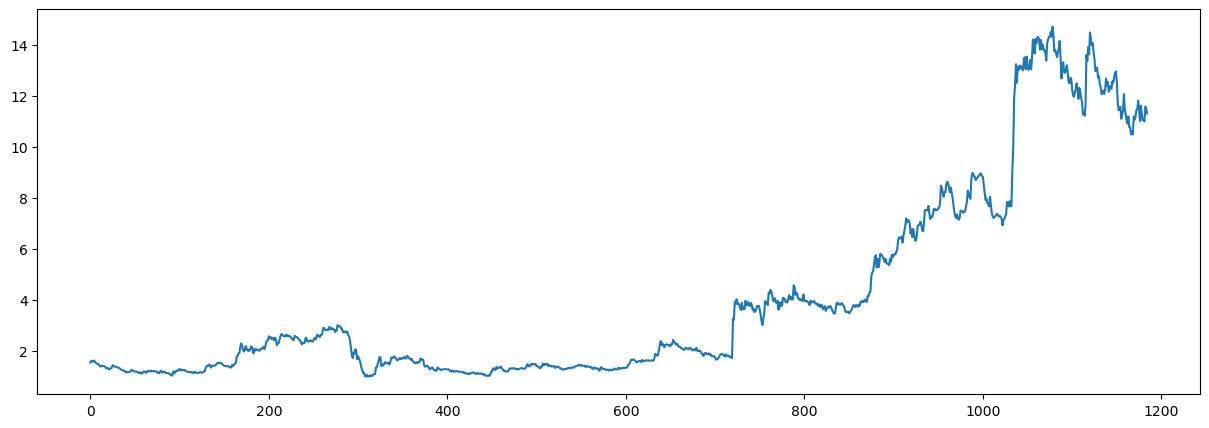

In [364]:
share_dummy = df[df.share == "NEU"]
_= share_dummy['Close'].plot(figsize=(15, 5))

# Next Graphs

In [365]:
df.head()

,date,level_0,share,Open,High,Low,Close,Volume,date_2,ASX200,...,date-3,Buy-Rolling-10-30-Cross,Sell-Rolling-10-30-Cross,Rolling-10-Previous-1,Rolling10Previous1Ratio,Rolling-30-Previous-1,Rolling30Previous1Ratio,Rolling10Previous1Ratio_Bucket,Buy_Cross_10_30,Sell_Cross_10_30
0,2019-01-02,606983,MND,13.49,13.88,13.49,13.65,149544,2019-01-02,0.0,...,2019-01-02,False,False,NaN,NaN,NaN,NaN,NaN,0,0
1,2019-01-03,606984,MND,13.13,14.06,13.13,13.95,128493,2019-01-03,0.0,...,2019-01-03,False,False,NaN,NaN,NaN,NaN,NaN,0,0
2,2019-01-04,606985,MND,13.63,13.70,13.49,13.64,142431,2019-01-04,0.0,...,2019-01-04,False,False,NaN,NaN,NaN,NaN,NaN,0,0
3,2019-01-07,606986,MND,13.68,14.25,13.63,14.24,131313,2019-01-07,0.0,...,2019-01-07,False,False,NaN,NaN,NaN,NaN,NaN,0,0
4,2019-01-08,606987,MND,14.06,14.13,13.82,14.03,451787,2019-01-08,0.0,...,2019-01-08,False,False,NaN,NaN,NaN,NaN,NaN,0,0


In [366]:
df = df.set_index('date')

<Axes: xlabel='date'>

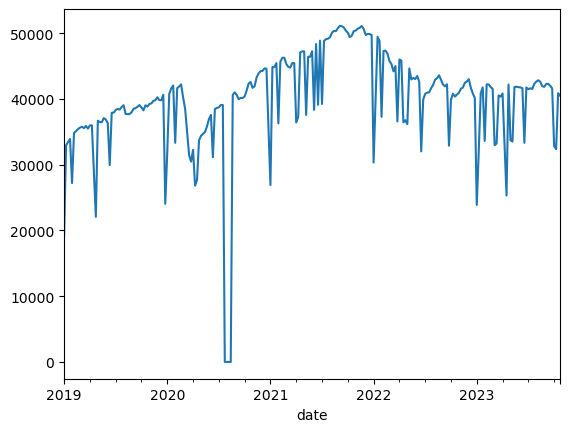

In [367]:
df['Close'].resample('W').sum().plot()

<Axes: xlabel='date'>

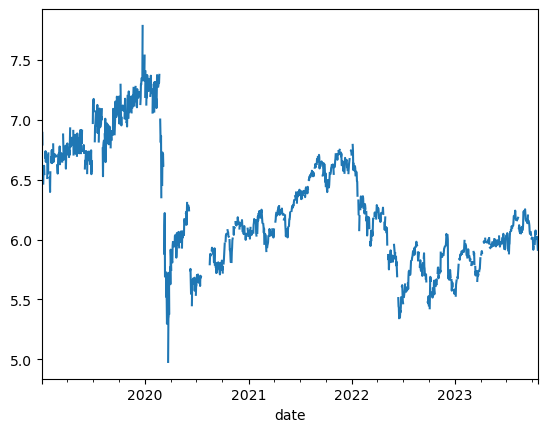

In [368]:
df['Close'].resample('D').mean().plot()

<Axes: xlabel='date'>

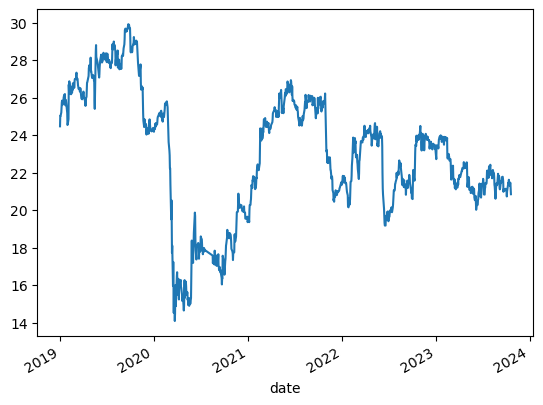

In [369]:
df[(df.share=='WBC')] ['Close'].plot()

In [370]:
print("Hello")

Hello


# Next

In [371]:
Combo_Buy_Sell_Next.head()

,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"


In [372]:
Combo_Buy_Sell_Next2= Combo_Buy_Sell_Next.copy()

In [373]:
Combo_Buy_Sell_Next2.head()


,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,Change_Close,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down
0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,-0.045,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,0.030,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,-0.040,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]"
3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,0.050,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"
4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,0.045,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]"


In [374]:
Combo_Buy_Sell_Next2=Combo_Buy_Sell_Next2.reset_index()

In [375]:
for i in range(0,len(Combo_Buy_Sell_Next2)):
    #print (i)
    temp = Combo_Buy_Sell_Next2.loc[i, "Change_Close_Ratio"]
     
    if temp > 1 :
    #print ("test")
        Combo_Buy_Sell_Next2.loc[i,'Gone up'] =  1
    else :
        Combo_Buy_Sell_Next2.loc[i,'Gone up'] =  0 

In [376]:
Combo_Buy_Sell_Next2.head()

,index,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,...,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down,Gone up
0,0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,...,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]",0.0
1,1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,...,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0
2,2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,...,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]",0.0
3,3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,...,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0
4,4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,...,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0


In [377]:
Combo_Buy_Sell_Next2['Gone up'].value_counts()

0.0    19654
1.0     8782
Name: Gone up, dtype: int64

In [378]:
#Combo_Buy_Sell_Next2 = pd.get_dummies(data = Combo_Buy_Sell_Next2, columns = ['gender', 'Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineS

In [379]:
#Combo_Buy_Sell_Next2= Combo_Buy_Sell_Next2.merge(df_sharematch[['share','ShareNumber']] , on = ['share'], how = 'left')

In [380]:
Combo_Buy_Sell_Next2.head()

,index,date,share,Option,Close,order,order_minus_one,sell_date,Option_Sell,Close_Sell,...,Change_Close_Ratio,Days_between,Days_between2,Ratio_Day,Ratio_220_Days,Close_Bucket,ASX200,Change_Close_Ratio_Bucket,Change_Close_Up_Down,Gone up
0,0,2019-12-03,14D,Buy,0.235,0.0,-1.0,2020-01-22,Sell,0.190,...,0.808511,50 days,50.0,0.016170,3.557447,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]",0.0
1,1,2020-04-23,14D,Buy,0.115,2.0,1.0,2020-06-11,Sell,0.145,...,1.260870,49 days,49.0,0.025732,5.661047,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0
2,2,2020-08-17,14D,Buy,0.165,4.0,3.0,2020-09-14,Sell,0.125,...,0.757576,28 days,28.0,0.027056,5.952381,"(0.1, 0.5]",0.0,"(0.75, 0.9]","(0, 1]",0.0
3,3,2020-10-06,14D,Buy,0.130,6.0,5.0,2020-11-26,Sell,0.180,...,1.384615,51 days,51.0,0.027149,5.972851,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0
4,4,2020-12-10,14D,Buy,0.180,8.0,7.0,2021-01-29,Sell,0.225,...,1.250000,50 days,50.0,0.025000,5.500000,"(0.1, 0.5]",0.0,"(1.1, 1.5]","(1, 100]",1.0


In [381]:
Combo_Buy_Sell_Next2 = Combo_Buy_Sell_Next2.drop(["Option","Ratio_Day","Ratio_220_Days","order","order_minus_one","Option_Sell","Days_between","share","Change_Close","Change_Close_Ratio"],axis=1)

In [382]:
#Combo_Buy_Sell_Next2 = Combo_Buy_Sell_Next2.drop(["ASX200"],axis=1) ## Will be OK later

In [383]:
Combo_Buy_Sell_Next2 = Combo_Buy_Sell_Next2.drop(["Close_Bucket","Change_Close_Ratio_Bucket"],axis=1)

In [384]:
Combo_Buy_Sell_Next2 = Combo_Buy_Sell_Next2.drop(["date", "sell_date"],axis=1) ## Will be OK later

In [385]:
Combo_Buy_Sell_Next2 = Combo_Buy_Sell_Next2.drop(["Change_Close_Up_Down"],axis=1) ## Will be OK later

In [386]:
Combo_Buy_Sell_Next2.head()

,index,Close,Close_Sell,Days_between2,ASX200,Gone up
0,0,0.235,0.190,50.0,0.0,0.0
1,1,0.115,0.145,49.0,0.0,1.0
2,2,0.165,0.125,28.0,0.0,0.0
3,3,0.130,0.180,51.0,0.0,1.0
4,4,0.180,0.225,50.0,0.0,1.0
